# Analysis Structure

1. exp sbs freqs versus chemical distance
2. fit quality 
    - on codon positions
    - on genes
    - on terminal and internal
    - on random spectra
    - on site rate cats

In [1]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from Bio import SeqIO

from pymutspec.draw import plot_mutspec12
from pymutspec.annotation import CodonAnnotation
from pymutspec.constants import possible_codons
# from pymutspec.io import read_genbank_ref

from scipy.spatial.distance import euclidean, cityblock, pdist, squareform
from scipy.stats import chisquare, ks_2samp, pearsonr, spearmanr, uniform
from scipy.special import kl_div
from sklearn.metrics import mean_squared_error, r2_score
import tqdm

from utils import (
    amino_acid_codes, alphabet, cdn_spectrum_to_matrix, 
    nuc_spectrum_to_matrix, collect_possible_changes,
    get_equilibrium_probabilities, plot_exp_heatmap,
    prepare_aa_subst, plot_aa_eq_freqs, prepare_exp_aa_subst,
    calc_metrics,weighted_average_percentage_error, get_equilibrium_freqs
)

In [2]:
coda = CodonAnnotation(1)

## Load reference and calc amino acid freqs

In [3]:
ref = next(SeqIO.parse("data/NC_045512.2.gb", "genbank"))
ref.features[:10]

[SeqFeature(SimpleLocation(ExactPosition(0), ExactPosition(29903), strand=1), type='source', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(0), ExactPosition(265), strand=1), type="5'UTR"),
 SeqFeature(SimpleLocation(ExactPosition(265), ExactPosition(21555), strand=1), type='gene', qualifiers=...),
 SeqFeature(CompoundLocation([SimpleLocation(ExactPosition(265), ExactPosition(13468), strand=1), SimpleLocation(ExactPosition(13467), ExactPosition(21555), strand=1)], 'join'), type='CDS', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(265), ExactPosition(805), strand=1), type='mat_peptide', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(805), ExactPosition(2719), strand=1), type='mat_peptide', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(2719), ExactPosition(8554), strand=1), type='mat_peptide', qualifiers=...),
 SeqFeature(SimpleLocation(ExactPosition(8554), ExactPosition(10054), strand=1), type='mat_peptide', qualifiers=...),
 SeqFeature(Simp

In [4]:
aa_freqs_df = pd.read_csv('./data/ref_aa_freqs.csv', index_col=0)
aa_freqs_df

R    V    C    G    S    A    L    T    P    D    Y    F    I  \
ORF1ab        113  228   88  149  162  179  233  182  110  178  140  142  128   
ORF1a;ORF1ab  131  371  138  264  294  309  435  345  164  211  195  208  215   
S              42   97   40   82   99   79  108   97   58   62   54   77   76   
ORF3a           6   25    7   14   22   13   30   24   12   13   17   14   21   
E               3   13    3    1    8    4   14    4    2    1    4    5    3   
M              14   12    4   14   15   19   35   13    5    6    9   11   20   
ORF6            1    3    0    0    4    1    8    3    1    4    2    3   10   
ORF7a           5    8    6    4    7    9   15   10    6    2    5   10    8   
ORF7b           0    1    2    0    2    2   11    1    0    2    1    6    5   
ORF8            4   12    7    5    9    5   10    5    7    7    7    8   10   
N              29    8    0   43   37   37   27   32   28   24   11   13   14   
ORF10           2    4    1    1    2    2    4    2    1    1    3    4    3   

                N    K    Q    E   H    M   W  
ORF1ab        151  158   88  101  70   63  32  
ORF1a;ORF1ab  233  276  151  239  75  105  46  
S              88   61   62   48  17   14  12  
ORF3a           8   11    9   11   8    4   6  
E               5    2    0    2   0    1   0  
M              11    7    4    7   5    4   7  
ORF6            4    4    3    5   1    3   1  
ORF7a           2    7    5    8   3    1   0  
ORF7b           1    0    1    3   2    2   1  
ORF8            2    5    6    6   4    1   1  
N              22   31   35   12   4    7   5  
ORF10           5    0    1    0   0    2   0

In [5]:
aa_freqs_total_dct = aa_freqs_df.rename(columns=amino_acid_codes).sum(0).to_dict()
aa_freqs_total_dct

{'Arg': 350,
 'Val': 782,
 'Cys': 296,
 'Gly': 577,
 'Ser': 661,
 'Ala': 659,
 'Leu': 930,
 'Thr': 718,
 'Pro': 394,
 'Asp': 511,
 'Tyr': 448,
 'Phe': 501,
 'Ile': 513,
 'Asn': 532,
 'Lys': 562,
 'Gln': 365,
 'Glu': 442,
 'His': 189,
 'Met': 207,
 'Trp': 111}

#### same for ORF1ab

In [6]:
_nfea = 15
ref_df2 = pd.DataFrame([f.qualifiers for f in ref.features if f.type == "mat_peptide"][:_nfea])
ref_df2.drop(columns=["locus_tag"], inplace=True)
ref_df2["gene"] = ref_df2["gene"].apply(lambda x: x[0])
ref_df2["product"] = ref_df2["product"].apply(lambda x: x[0])
ref_df2["protein_id"] = ref_df2["protein_id"].apply(lambda x: x[0])

pr_seqs = [str(f.extract(ref.seq).translate(table=1, )) for f in ref.features if f.type == "mat_peptide"][:_nfea]
ref_df2["translation"] = pr_seqs
# ref_df2["is_in_ORF1ab"] = ref_df2["translation"].apply(lambda x: x in ref_df.loc[0, "translation"] or x in ref_df.loc[1, "translation"])

ref_df2.loc[0, "product"] = 'nsp1'
ref_df2.loc[4, "product"] = 'nsp5 (Mpro)'
ref_df2.loc[10, "product"] = 'nsp12 (RdRp)'
ref_df2.loc[11, "product"] = 'nsp13'
ref_df2.loc[12, "product"] = 'nsp14'
ref_df2.loc[13, "product"] = 'nsp15'
ref_df2.loc[14, "product"] = 'nsp16'

ref_df2["size"] = ref_df2["translation"].str.len()
# ref_df2 = ref_df2.query('size > 100')
# ref_df2 = ref_df2[ref_df2['product'] != 'ORF1a polyprotein']
# ref_df2.to_csv('./data/ref_proteins.csv', index=False)
ref_df2.head()

gene      product                                               note  \
0  ORF1ab         nsp1            [nsp1; produced by both pp1a and pp1ab]   
1  ORF1ab         nsp2                  [produced by both pp1a and pp1ab]   
2  ORF1ab         nsp3  [former nsp1; conserved domains are: N-termina...   
3  ORF1ab         nsp4  [nsp4B_TM; contains transmembrane domain 2 (TM...   
4  ORF1ab  nsp5 (Mpro)  [nsp5A_3CLpro and nsp5B_3CLpro; main proteinas...   

       protein_id                                        translation  size  
0  YP_009725297.1  MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHL...   180  
1  YP_009725298.1  AYTRYVDNNFCGPDGYPLECIKDLLARAGKASCTLSEQLDFIDTKR...   638  
2  YP_009725299.1  APTKVTFGDDTVIEVQGYKSVNITFELDERIDKVLNEKCSAYTVEL...  1945  
3  YP_009725300.1  KIVNNWLKQLIKVTLVFLFVAAIFYLITPVHVMSKHTDFSSEIIGY...   500  
4  YP_009725301.1  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...   306

In [7]:
aa_freqs_df_orf1ab = pd.DataFrame(ref_df2.set_index('product')['translation']\
                           .apply(Counter).to_dict()).T.fillna(0).astype(int)
aa_freqs_df_orf1ab.to_csv('./data/ref_aa_freqs_orf1ab.csv')
aa_freqs_df_orf1ab

M    E    S    L    V   P   G   F    N    K    T   H   Q   R  \
nsp1           3   18   10   21   21   8  22   5    6    9    7   7   7  10   
nsp2          10   54   36   60   46  22  49  30   31   51   46   9  18  19   
nsp3          37  119  139  178  165  74  98  80  113  140  164  35  68  45   
nsp4           9   15   38   49   46  20  27  37   21   17   41   9   9  20   
nsp5 (Mpro)   10    9   16   29   27  13  26  17   21   11   24   7  14  11   
nsp6          17    3   17   41   28   7  15  22   10   12   21   4   7   9   
nsp7           4    5   10   15    9   0   1   1    3    6    4   1   6   2   
nsp8           9    9   15   18   13   6   3   5   13   15   13   0  11   7   
nsp9           2    3    5   15    6   6   9   4    7    7   12   0   4   6   
nsp10          4    4    6    8    9   8  13   5    7    8   13   3   6   2   
nsp12 (RdRp)  25   31   53   83   74  30  45  57   56   51   61  27  28  43   
nsp13          8   23   40   50   53  30  32  24   30   34   50  12  18  30   
nsp14         13   16   28   40   44  26  30  30   28   30   32  20  16  22   
nsp15          5   23   20   29   38  14  22  21   17   25   21   6  15   9   
nsp16         12    8   23   32   19  10  20  11   21   18   18   5  12   9   

                D    A   C   Y   I   W  
nsp1            9    7   1   5   3   1  
nsp2           20   44  27  19  40   7  
nsp3          103  126  51  95  97  18  
nsp4           22   36  16  32  30   6  
nsp5 (Mpro)    17   17  12  11  11   3  
nsp6            8   20  10  17  16   6  
nsp7            5    5   3   0   2   1  
nsp8           13   28   2   6  10   2  
nsp9            6   10   3   5   2   1  
nsp10           7   13  13   5   4   1  
nsp12 (RdRp)   75   64  29  58  33   9  
nsp13          29   46  26  34  29   3  
nsp14          34   35  23  25  25  10  
nsp15          23   16   5  11  23   3  
nsp16          18   20   5  12  18   7

## Load spectrum and calculate expected AA subst matrix and equilibrium

In [6]:
## read external clades spectra
# https://raw.githubusercontent.com/jbloomlab/SARS2-mut-spectrum/refs/heads/main/results/synonymous_mut_rates/rates_by_clade.csv

clades_spectra = pd.read_csv('data/bloom_etal/rates_by_clade.csv').query('subset == "all"')
clades_spectra['Mut'] = clades_spectra['mut_type'].str.replace('to', '>')
spectrum_20A = clades_spectra[clades_spectra['clade'] == '20A'].copy()
spectrum_20A['rate'] /= spectrum_20A['rate'].sum()
spectrum_24A = clades_spectra[clades_spectra['clade'] == '24A'].copy()
spectrum_24A['rate'] /= spectrum_24A['rate'].sum()
spectrum_20A

subset clade mut_type  count  total_count  fraction parent_nt  \
0     all   20A     AtoC    305        18970  0.016078         A   
1     all   20A     AtoG   1778        18970  0.093727         A   
2     all   20A     AtoT    588        18970  0.030996         A   
3     all   20A     CtoA    384        18970  0.020242         C   
4     all   20A     CtoG    135        18970  0.007117         C   
5     all   20A     CtoT   7840        18970  0.413280         C   
6     all   20A     GtoA    878        18970  0.046284         G   
7     all   20A     GtoC    140        18970  0.007380         G   
8     all   20A     GtoT   2906        18970  0.153190         G   
9     all   20A     TtoA    639        18970  0.033685         T   
10    all   20A     TtoC   2912        18970  0.153510         T   
11    all   20A     TtoG    465        18970  0.024512         T   

    parent_nt_frac      rate  Mut  
0         0.289560  0.007540  A>C  
1         0.289560  0.043953  A>G  
2         0.289560  0.014536  A>T  
3         0.135130  0.020341  C>A  
4         0.135130  0.007151  C>G  
5         0.135130  0.415293  C>T  
6         0.064585  0.097310  G>A  
7         0.064585  0.015516  G>C  
8         0.064585  0.322075  G>T  
9         0.510720  0.008956  T>A  
10        0.510720  0.040812  T>C  
11        0.510720  0.006517  T>G

In [7]:
_clades_order = clades_spectra.drop_duplicates(subset='clade').set_index('clade')

_1 = {x:'Early clades' for x in _clades_order.loc[:'21J'].index.unique()}
_2 = {x:'Late clades\n(Omicron+)' for x in _clades_order.loc['21K':].index.unique()}

_clade2label = {**_1, **_2}
_clade2label

{'20A': 'Early clades',
 '20B': 'Early clades',
 '20C': 'Early clades',
 '20E': 'Early clades',
 '20G': 'Early clades',
 '20I': 'Early clades',
 '20J': 'Early clades',
 '21C': 'Early clades',
 '21I': 'Early clades',
 '21J': 'Early clades',
 '21K': 'Late clades\n(Omicron+)',
 '21L': 'Late clades\n(Omicron+)',
 '22A': 'Late clades\n(Omicron+)',
 '22B': 'Late clades\n(Omicron+)',
 '22C': 'Late clades\n(Omicron+)',
 '22D': 'Late clades\n(Omicron+)',
 '22E': 'Late clades\n(Omicron+)',
 '22F': 'Late clades\n(Omicron+)',
 '23A': 'Late clades\n(Omicron+)',
 '23B': 'Late clades\n(Omicron+)',
 '23C': 'Late clades\n(Omicron+)',
 '23D': 'Late clades\n(Omicron+)',
 '23F': 'Late clades\n(Omicron+)',
 '24A': 'Late clades\n(Omicron+)'}

### Plots

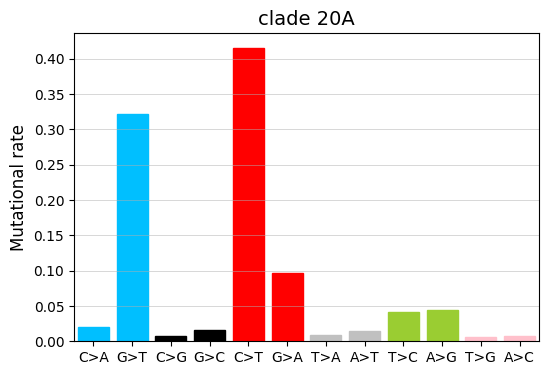

In [11]:
ax = plot_mutspec12(spectrum_20A, 'rate', 'clade 20A', 
               ylabel='Mutational rate', ticksize=10,
            #    savepath='./figures/20A_spectrum.png'
)

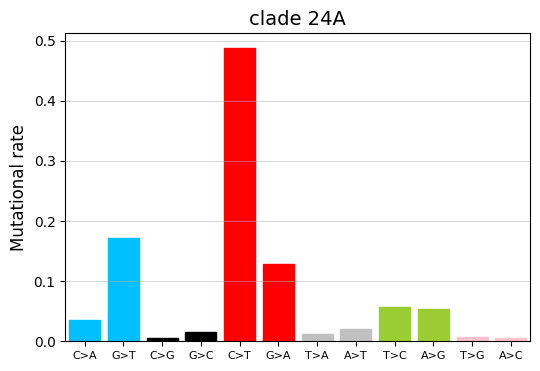

In [12]:
ax = plot_mutspec12(spectrum_24A, 'rate', 'clade 24A', 
               ylabel='Mutational rate', 
            #    savepath='./figures/20A_spectrum.png'
)

### qualitative model

In [105]:
aa_flows = df_changes\
    .query('(sbs == "C>T" | sbs == "G>T") & aa1 != "*" & aa2 != "*" & aa1 != aa2')\
    .groupby(['aa1', 'aa2']).rate.count().reset_index()

inflow = aa_flows.groupby('aa2').rate.sum().rename('inflow')
outflow = aa_flows.groupby('aa1').rate.sum().rename('outflow')
inflow.index.name='aa'
outflow.index.name='aa'
_flow = inflow.to_frame().join(outflow, how='outer').fillna(0).astype(int)
_flow['flow'] = _flow['inflow'] - _flow['outflow']
_flow.sort_values('flow')[['flow']].T

aa    Arg  Ala  Pro  Gly  Thr  Glu  His  Gln  Lys  Asp  Trp  Asn  Met  Cys  \
flow  -10   -8   -8   -7   -4   -1   -1   -1   -1   -1    0    1    1    3   

aa    Ser  Tyr  Val  Ile  Phe  Leu  
flow    3    4    4    7    9   10

In [106]:
aa_flows.query('aa1 == "Ser" | aa2 == "Ser"')

aa1  aa2  rate
0   Ala  Ser     4
6   Arg  Ser     1
20  Pro  Ser     4
21  Ser  Ile     2
22  Ser  Leu     2
23  Ser  Phe     2

In [107]:
_flow.sort_values('flow')

inflow  outflow  flow
aa                        
Arg       0       10   -10
Ala       0        8    -8
Pro       0        8    -8
Gly       0        7    -7
Thr       0        4    -4
Glu       0        1    -1
His       1        2    -1
Gln       0        1    -1
Lys       0        1    -1
Asp       1        2    -1
Trp       2        2     0
Asn       1        0     1
Met       2        1     1
Cys       5        2     3
Ser       9        6     3
Tyr       4        0     4
Val       8        4     4
Ile       7        0     7
Phe       9        0     9
Leu      13        3    10

In [ ]:
eq_freqs_aa = eq_freqs_cdn[eq_freqs_cdn.aa !='*'].groupby('aa')['freq'].sum()
eq_freqs_aa /= eq_freqs_aa.sum()
eq_freqs_aa = eq_freqs_aa.sort_values(ascending=False).reset_index()
eq_freqs_aa.T

0         1         2         3         4         5         6   \
aa         Phe       Leu       Ser       Ile       Tyr       Val       Cys   
freq  0.314637  0.197825  0.119281  0.086898  0.073639  0.044165  0.035283   

            7         8         9         10        11        12        13  \
aa         Thr       His       Pro       Asn       Arg       Asp       Ala   
freq  0.025257  0.020183  0.017862  0.017199  0.009142  0.008012  0.007127   

            14        15        16        17        18        19  
aa         Met       Gln       Lys       Gly       Glu       Trp  
freq  0.006878  0.005073  0.004677  0.002844  0.002015  0.002004

## Load OBS

In [8]:
obs_raw = pd.read_csv('data/bloom_etal/aggregated.csv').query('subset == "all" & exclude == False')
obs_raw['Mut'] = obs_raw['nt_mutation'].str[0] + '>' + obs_raw['nt_mutation'].str[-1]
obs = obs_raw.query('synonymous == False & noncoding == False').drop(['synonymous', 'noncoding', 'four_fold_degenerate'], axis=1)

def _same_aa_mut(aa_mutation: str):
    variants = aa_mutation.split(';')
    return variants.count(variants[0]) == len(variants)

obs = obs[obs.aa_mutation.apply(_same_aa_mut)]
obs['aa1'] = obs['aa_mutation'].str[0]
obs['aa2'] = obs['aa_mutation'].str[-1]
# same as in the paper table
# obs[obs.four_fold_degenerate].groupby('clade')['count'].sum().sort_index()
obs

protein    aa_mutation nt_mutation     codon_change  nt_site  \
0              ORF1ab         P5401L     C16466T          CCA>CTA    16466   
1                   M           I82T     T26767C          ATC>ACC    26767   
3              ORF1ab         P4715L     C14408T          CCT>CTT    14408   
4              ORF1ab         A6319V     C19220T          GCT>GTT    19220   
5              ORF1ab         I5658V     A17236G          ATA>GTA    17236   
...               ...            ...         ...              ...      ...   
1553870  ORF1a;ORF1ab  V4369A;V4369A     T13371C  GTC>GCC;GTC>GCC    13371   
1553871  ORF1a;ORF1ab  V4350A;V4350A     T13314C  GTA>GCA;GTA>GCA    13314   
1553874  ORF1a;ORF1ab  V3763F;V3763F     G11552T  GTT>TTT;GTT>TTT    11552   
1553875  ORF1a;ORF1ab  V3759G;V3759G     T11541G  GTT>GGT;GTT>GGT    11541   
1553876  ORF1a;ORF1ab  V4102A;V4102A     T12570C  GTA>GCA;GTA>GCA    12570   

        reference_nt clade_founder_nt  exclude  count  count_terminal  \
0                  C                C    False     70              37   
1                  T                T    False     58              18   
3                  C                C    False     52              26   
4                  C                C    False     50              15   
5                  A                A    False     48              24   
...              ...              ...      ...    ...             ...   
1553870            T                T    False      1               1   
1553871            T                T    False      1               1   
1553874            G                G    False      1               1   
1553875            T                T    False      1               0   
1553876            T                T    False      1               0   

         count_non_terminal  mean_log_size clade subset    codon  \
0                        33       0.708825   19A    all      CCA   
1                        40       1.237886   19A    all      ATC   
3                        26       0.678436   19A    all      CCT   
4                        35       1.097059   19A    all      GCT   
5                        24       0.581333   19A    all      ATA   
...                     ...            ...   ...    ...      ...   
1553870                   0       0.000000   24E    all  GTC;GTC   
1553871                   0       0.000000   24E    all  GTA;GTA   
1553874                   0       0.000000   24E    all  GTT;GTT   
1553875                   1       0.693147   24E    all  GTT;GTT   
1553876                   1       1.098612   24E    all  GTA;GTA   

        codon_position codon_site  Mut aa1 aa2  
0                    2       5401  C>T   P   L  
1                    2         82  T>C   I   T  
3                    2       4715  C>T   P   L  
4                    2       6319  C>T   A   V  
5                    1       5658  A>G   I   V  
...                ...        ...  ...  ..  ..  
1553870            2;2  4369;4369  T>C   V   A  
1553871            2;2  4350;4350  T>C   V   A  
1553874            1;1  3763;3763  G>T   V   F  
1553875            2;2  3759;3759  T>G   V   G  
1553876            2;2  4102;4102  T>C   V   A  

[440648 rows x 20 columns]

## Explore OBS

### Basic features

In [6]:
obs_raw['count'].sum()

np.int64(5635999)

In [51]:
obs.codon_position.value_counts()

codon_position
1      110949
2      100113
1;1     89804
2;2     87542
3       29004
3;3     23236
Name: count, dtype: int64

In [52]:
obs_raw['count'].sum(), obs['count'].sum()

(np.int64(5635999), np.int64(3175359))

In [53]:
print('Number of mutations:')
obs_raw.groupby(['clade', 'synonymous'])['count'].sum().unstack()

Number of mutations:


synonymous    False   True 
clade                      
19A            7462    3999
20A           67405   43933
20B           56079   36627
20C           56285   37562
20E           38269   24958
20F            2218    1300
20G           52212   36639
20I          217281  146099
20J           17075   12236
21C           23617   16296
21I           86071   55531
21J         1032287  643592
21K          393196  295375
21L          315056  250437
22A           43079   35461
22B          348753  270719
22C           61092   47564
22D           21735   16967
22E           96306   78990
22F           20684   16505
23A           96095   75345
23B           31774   25859
23C           16612   13041
23D           32087   25902
23E           12181    9604
23F           45178   37377
24A           67943   58881
24B            9791    8564
24C            9769    8829
24E           12967   11248

In [54]:
obs_raw.groupby(['clade', 'synonymous'])['count'].sum().unstack().shape

(30, 2)

In [55]:
print('Number of mutations:')
obs_raw.query('synonymous == True').groupby(['clade', 'four_fold_degenerate'])['count'].sum().unstack()

Number of mutations:


four_fold_degenerate   False   True 
clade                               
19A                     2299    1700
20A                    24963   18970
20B                    20543   16084
20C                    21405   16157
20E                    14092   10866
20F                      758     542
20G                    21294   15345
20I                    84469   61630
20J                     6871    5365
21C                     9495    6801
21I                    30942   24589
21J                   356462  287130
21K                   171324  124051
21L                   146835  103602
22A                    20676   14785
22B                   158444  112275
22C                    28027   19537
22D                     9550    7417
22E                    46045   32945
22F                     9294    7211
23A                    43016   32329
23B                    14765   11094
23C                     7578    5463
23D                    14918   10984
23E                     5530    4074
23F                    21588   15789
24A                    34504   24377
24B                     5131    3433
24C                     5143    3686
24E                     6636    4612

In [56]:
obs.groupby('clade')['count'].sum().rename('aa_subst_cnt').sort_index().reset_index()

clade  aa_subst_cnt
0    19A          7185
1    20A         65078
2    20B         54164
3    20C         54346
4    20E         36904
5    20F          2161
6    20G         50463
7    20I        210313
8    20J         16464
9    21C         22742
10   21I         82872
11   21J        998289
12   21K        379267
13   21L        303609
14   22A         41499
15   22B        335444
16   22C         58845
17   22D         20777
18   22E         93354
19   22F         19810
20   23A         92364
21   23B         30556
22   23C         15938
23   23D         30973
24   23E         11722
25   23F         43582
26   24A         65370
27   24B          9422
28   24C          9371
29   24E         12475

### terminal vs non-terminal spectrum and mutations

1.2971005556962407


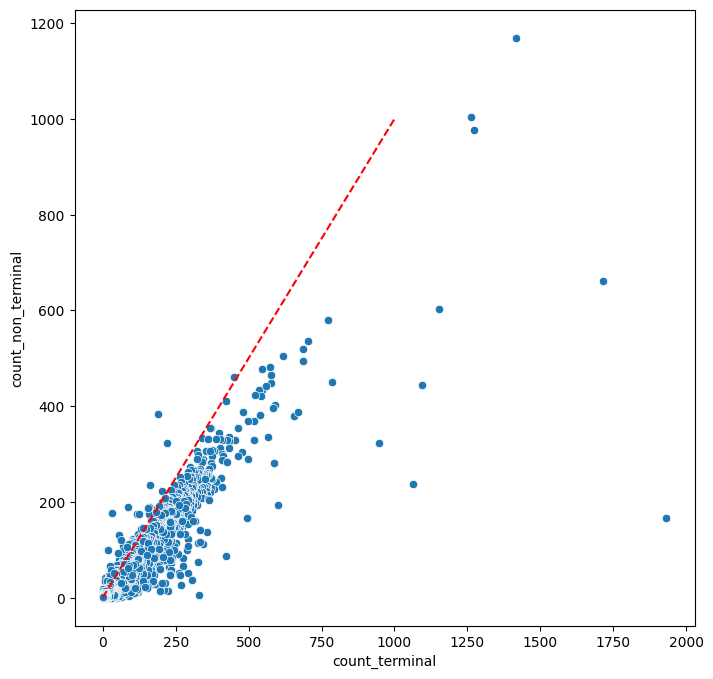

In [14]:
plt.figure(figsize=(8, 8))
sns.scatterplot(obs, x='count_terminal', y='count_non_terminal')
plt.plot([0, 1000],[0, 1000], 'r--')
print((obs.count_terminal / obs.count_non_terminal).replace(np.inf, np.nan).mean())

In [ ]:
# Compare spectra terminal vs non-terminal

_ = obs_raw.query('four_fold_degenerate == True')\
    .groupby(['clade', 'Mut'])[['count_terminal', 'count_non_terminal']].sum()\
        .melt(ignore_index=False, value_name='ObsNum', var_name='tree_set').reset_index()\
            .pivot(index=['clade','tree_set'], columns='Mut', values='ObsNum')

print('ter and non-ter spectra for clades:\n\nclade, cossim, ter_mut_frac, PE_mean(%)')
for cl in _.index.get_level_values(0).unique():
    curd = _.loc[cl]
    _nmuts = curd.sum(axis=1).values
    if _nmuts.sum() < 5000:
        continue
    ter_frac = _nmuts[1] / _nmuts.sum()
    cossim = 1-pdist(curd, 'cosine')[0]

    curs = curd.T / curd.sum(1)
    curs['pe'] = (curs['count_terminal'] - curs['count_non_terminal']) \
        / curs['count_terminal'] * 100
    
    print(f'{cl}    {cossim:.4f}  {ter_frac:.3f}         {curs['pe'].abs().mean():.2f}')


ter and non-ter spectra for clades:

clade, cossim, ter_mut_frac, PE_mean(%)
20A    0.9989  0.555         10.59
20B    0.9968  0.565         12.57
20C    0.9958  0.576         16.14
20E    0.9973  0.567         14.56
20G    0.9995  0.565         11.98
20I    0.9992  0.558         9.48
20J    0.9993  0.611         10.33
21C    0.9984  0.550         11.57
21I    0.9985  0.586         10.98
21J    0.9989  0.580         9.63
21K    0.9985  0.642         10.43
21L    0.9993  0.600         6.89
22A    0.9998  0.616         9.79
22B    0.9991  0.597         7.61
22C    0.9994  0.649         8.91
22D    0.9993  0.572         7.41
22E    0.9988  0.600         8.43
22F    0.9989  0.611         21.27
23A    0.9994  0.585         9.71
23B    0.9995  0.569         11.63
23C    0.9976  0.574         17.22
23D    0.9996  0.577         9.27
23F    0.9994  0.605         9.02
24A    0.9997  0.640         10.56


## compare obs and exp with chemical distance

In [11]:
grantham = pd.read_csv('../grantham.tsv', sep='\t', index_col=0).replace(0, np.nan)
grantham.index.name = 'aa1'
grantham_long = grantham.melt(ignore_index=False, var_name='aa2', value_name='granthamD').dropna().reset_index()
grantham_long['aa1'] = grantham_long['aa1'].map(amino_acid_codes)
grantham_long['aa2'] = grantham_long['aa2'].map(amino_acid_codes)
grantham_long = pd.concat([grantham_long, grantham_long.rename(columns={'aa1':'aa2', 'aa2':'aa1'})], ignore_index=True)
grantham_long

aa1  aa2  granthamD
0    Ser  Arg      110.0
1    Ser  Leu      145.0
2    Arg  Leu      102.0
3    Ser  Pro       74.0
4    Arg  Pro      103.0
..   ...  ...        ...
375  Trp  Asn      174.0
376  Trp  Lys      110.0
377  Trp  Asp      181.0
378  Trp  Glu      152.0
379  Trp  Met       67.0

[380 rows x 3 columns]

In [53]:
obs_clade = obs[obs['clade'] == '20A']
exp_aa_subst, _ = prepare_exp_aa_subst(spectrum_20A)
aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, aa_freqs_total_dct)
aa_subst['label'] = aa_subst.aa1 + '>' + aa_subst.aa2
aa_subst['pe'] = aa_subst['pe'].replace(-np.inf, 0)
aa_subst['diff_freqs_abs'] = (aa_subst['nobs_freqs'] - aa_subst['nexp_freqs']).abs()
aa_subst['division'] = (aa_subst['nobs_freqs'] / aa_subst['nexp_freqs'])
aa_subst['dist_to_diagonal'] = aa_subst['diff_freqs_abs'] / (2**0.5)
aa_subst = aa_subst.merge(grantham_long, 'left')
aa_subst.sort_values('pe')

aa1  aa2    nobs  ref_aa1_freq  nobs_scaled  rate_exp         nexp  \
57   Gly  Trp    11.0      0.059192     9.389043  0.322075   675.334620   
18   Arg  Trp    47.0      0.035905    66.135441  0.429829   901.276603   
15   Arg  Pro     9.0      0.035905    12.664233  0.062066   130.141215   
12   Arg  Leu   234.0      0.035905   329.270066  1.288299  2701.338481   
1    Ala  Glu    22.0      0.067604    16.441510  0.040682    85.303028   
..   ...  ...     ...           ...          ...       ...          ...   
96   Met  Thr   171.0      0.021235   406.846143  0.040812    85.576362   
85   Lys  Arg  1036.0      0.057653   907.878806  0.087906   184.324013   
103  Phe  Val   137.0      0.051395   134.675092  0.013034    27.330566   
45   Glu  Ala   178.0      0.045343   198.336284  0.015079    31.618496   
97   Met  Val   254.0      0.021235   604.321171  0.043953    92.162006   

            diff           pe  nobs_freqs  nexp_freqs    label  \
57   -665.945578 -7092.795348    0.000146    0.010482  Gly>Trp   
18   -835.141162 -1262.774019    0.001026    0.013988  Arg>Trp   
15   -117.476982  -927.628060    0.000197    0.002020  Arg>Pro   
12  -2372.068414  -720.402082    0.005110    0.041926  Arg>Leu   
1     -68.861518  -418.827209    0.000255    0.001324  Ala>Glu   
..           ...          ...         ...         ...      ...   
96    321.269781    78.965915    0.006314    0.001328  Met>Thr   
85    723.554793    79.697289    0.014091    0.002861  Lys>Arg   
103   107.344525    79.706295    0.002090    0.000424  Phe>Val   
45    166.717788    84.058139    0.003078    0.000491  Glu>Ala   
97    512.159165    84.749499    0.009379    0.001430  Met>Val   

     diff_freqs_abs  division  dist_to_diagonal  granthamD  
57         0.010336  0.013903          0.007309      184.0  
18         0.012962  0.073380          0.009165      101.0  
15         0.001823  0.097311          0.001289      103.0  
12         0.036816  0.121891          0.026033      102.0  
1          0.001069  0.192742          0.000756      107.0  
..              ...       ...               ...        ...  
96         0.004986  4.754188          0.003526       81.0  
85         0.011230  4.925451          0.007941       26.0  
103        0.001666  4.927636          0.001178       50.0  
45         0.002588  6.272793          0.001830      107.0  
97         0.007949  6.557162          0.005621       21.0  

[150 rows x 16 columns]

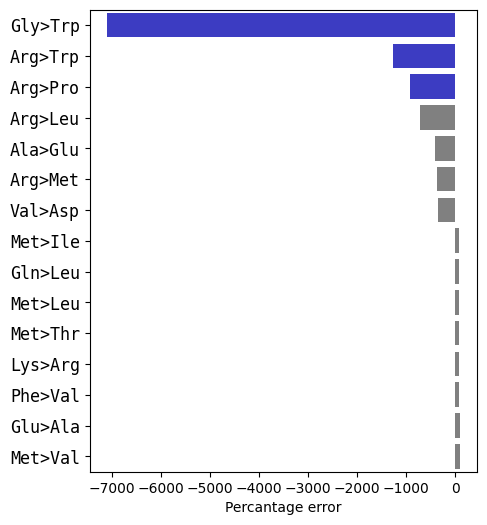

In [54]:
a = aa_subst['pe'][aa_subst['pe']>0].quantile(0.9)
b = aa_subst['pe'][aa_subst['pe']<0].quantile(0.1)

_d = aa_subst[(aa_subst['pe'] > a) | (aa_subst['pe'] < b)].copy()

plt.figure(figsize=(5, 6))
sns.barplot(aa_subst, y='label', x='pe', color='gray',
            order=_d.sort_values('pe').label)

# sns.barplot(aa_subst, y='label', x='pe', color='red', alpha=0.7,
#             order=_d.sort_values('pe').tail(3).label)
sns.barplot(aa_subst, y='label', x='pe', color='blue', alpha=0.7,
            order=_d.sort_values('pe').head(3).label)

plt.ylabel('')
# plt.xlim(-0.45, 0.45)
plt.xlabel('Percantage error')
plt.yticks(fontsize=12, fontname='monospace')
plt.show()

<Axes: >

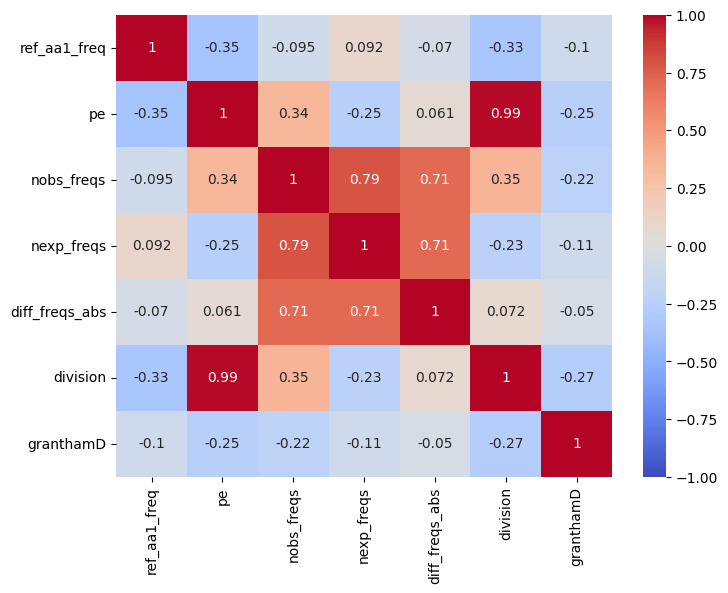

In [55]:
plt.figure(figsize=(8, 6))
sns.heatmap(aa_subst.drop(['aa1', 'aa2', 'label', 'nobs', 'nexp', 
                           'nobs_scaled', 'dist_to_diagonal', 'diff', 'rate_exp'], 
            axis=1).corr('spearman'), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)

Spearman correlation: -0.05, p-value: 0.5435


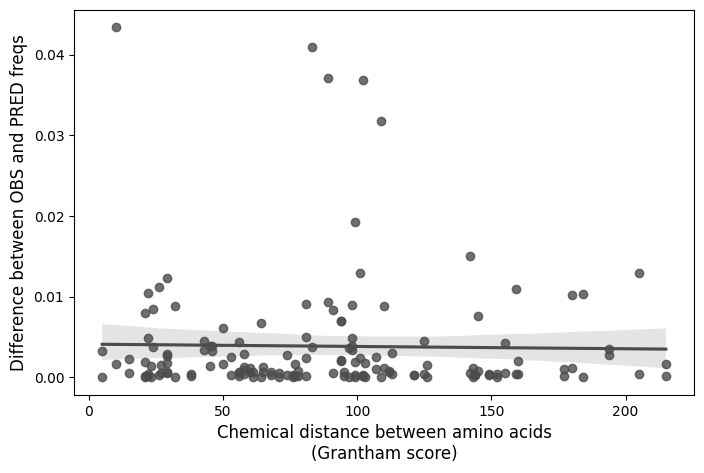

In [32]:
plt.figure(figsize=(8, 5))
sns.regplot(aa_subst, x='granthamD', y='diff_freqs_abs', color='.3')
plt.xlabel('Chemical distance between amino acids\n(Grantham score)', fontsize=12)
plt.ylabel('Difference between OBS and PRED freqs', fontsize=12)
cor = spearmanr(aa_subst['granthamD'], aa_subst['diff_freqs_abs'])
print(f'Spearman correlation: {cor.correlation:.2f}, p-value: {cor.pvalue:.4f}')

Text(42.33322222222222, 0.5, 'Difference between OBS and PRED freqs')

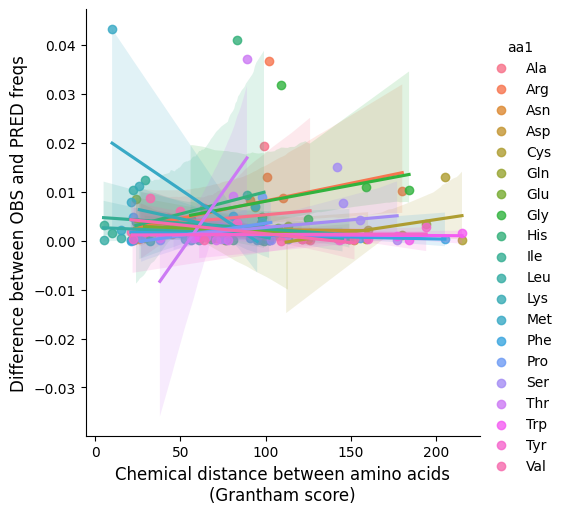

In [35]:
sns.lmplot(aa_subst, x='granthamD', y='diff_freqs_abs', hue='aa1')
plt.xlabel('Chemical distance between amino acids\n(Grantham score)', fontsize=12)
plt.ylabel('Difference between OBS and PRED freqs', fontsize=12)

Pearson correlation: -0.10, p-value: 0.2448


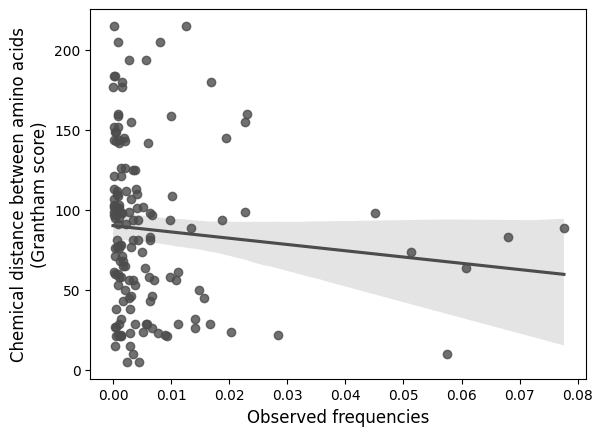

In [61]:
# fig 3a in https://link.springer.com/article/10.1186/gb-2003-4-11-r72
sns.regplot(aa_subst, y='granthamD', x='nobs_freqs', color='.3')
plt.xlabel('Observed frequencies', fontsize=12)
plt.ylabel('Chemical distance between amino acids\n(Grantham score)', fontsize=12)
cor = pearsonr(aa_subst.granthamD, aa_subst.nobs_freqs)
print(f'Pearson correlation: {cor.correlation:.2f}, p-value: {cor.pvalue:.4f}')

Text(0, 0.5, 'Chemical distance between amino acids\n(Grantham score)')

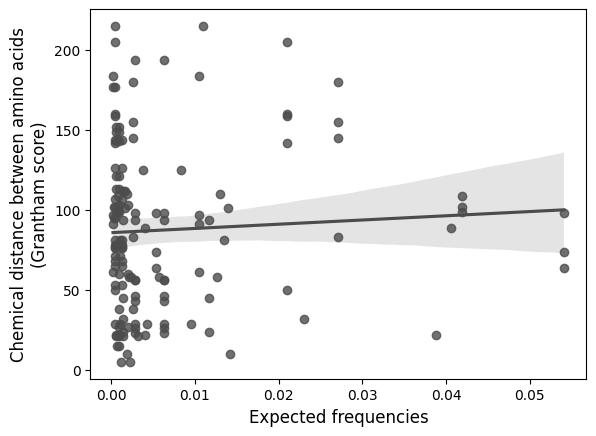

In [58]:
sns.regplot(aa_subst, y='granthamD', x='nexp_freqs', color='.3')
plt.xlabel('Expected frequencies', fontsize=12)
plt.ylabel('Chemical distance between amino acids\n(Grantham score)', fontsize=12)

Pearson correlation: -0.23, p-value: 0.0048


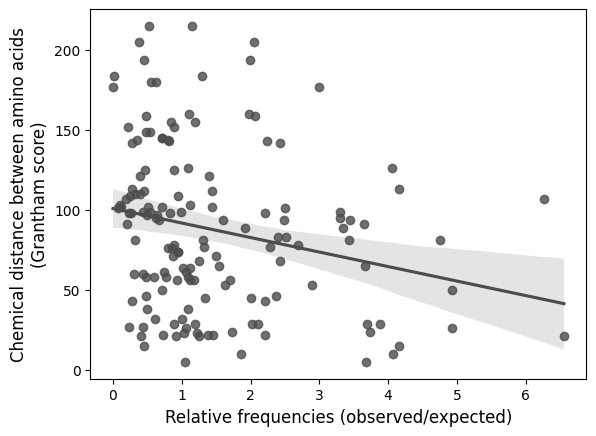

In [57]:
# fig 3b in https://link.springer.com/article/10.1186/gb-2003-4-11-r72
sns.regplot(aa_subst, y='granthamD', x='division', color='.3')
plt.xlabel('Relative frequencies (observed/expected)', fontsize=12)
plt.ylabel('Chemical distance between amino acids\n(Grantham score)', fontsize=12)
cor = pearsonr(aa_subst.granthamD, aa_subst.division)
print(f'Pearson correlation: {cor.correlation:.2f}, p-value: {cor.pvalue:.4f}')

In [46]:
_d = []
for clade, cur_obs in obs.groupby('clade'):
    exp_aa_subst, _ = prepare_exp_aa_subst(spectrum_20A)
    aa_subst = prepare_aa_subst(cur_obs, exp_aa_subst, aa_freqs_total_dct)
    _d.append(aa_subst.assign(clade=clade))

aa_subst_clades = pd.concat(_d, ignore_index=True)
aa_subst_clades['obs_relative_freq'] = (aa_subst_clades['nobs_freqs'] / aa_subst_clades['nexp_freqs'])
aa_subst_clades = aa_subst_clades.merge(grantham_long, 'left')
aa_subst_clades

aa1  aa2   nobs  ref_aa1_freq  nobs_scaled  rate_exp        nexp  \
0     Ala  Asp   22.0      0.067604    16.637818  0.040682    9.434424   
1     Ala  Glu    2.0      0.067604     1.512529  0.040682    9.434424   
2     Ala  Gly    6.0      0.067604     4.537587  0.028605    6.633698   
3     Ala  Pro    8.0      0.067604     6.050116  0.062066   14.393480   
4     Ala  Ser  223.0      0.067604   168.646976  1.288299  298.765160   
...   ...  ...    ...           ...          ...       ...         ...   
4495  Val  Gly   12.0      0.080222     7.583982  0.026069   10.523992   
4496  Val  Ile  270.0      0.080222   170.639596  0.291929  117.853036   
4497  Val  Leu  175.0      0.080222   110.599738  0.706215  285.102725   
4498  Val  Met   37.0      0.080222    23.383945  0.097310   39.284345   
4499  Val  Phe  179.0      0.080222   113.127732  0.644149  260.046436   

            diff          pe  nobs_freqs  nexp_freqs clade  obs_relative_freq  \
0       7.203394   43.295305    0.002335    0.001324   19A           1.763522   
1      -7.921895 -523.751645    0.000212    0.001324   19A           0.160320   
2      -2.096111  -46.194394    0.000637    0.000931   19A           0.684021   
3      -8.343364 -137.904207    0.000849    0.002020   19A           0.420337   
4    -130.118184  -77.154176    0.023666    0.041926   19A           0.564480   
...          ...         ...         ...         ...   ...                ...   
4495   -2.940010  -38.766050    0.000611    0.000848   24E           0.720637   
4496   52.786560   30.934532    0.013756    0.009500   24E           1.447902   
4497 -174.502987 -157.778843    0.008916    0.022983   24E           0.387929   
4498  -15.900401  -67.997085    0.001885    0.003167   24E           0.595248   
4499 -146.918704 -129.869751    0.009120    0.020963   24E           0.435029   

      granthamD  
0         126.0  
1         107.0  
2          60.0  
3          27.0  
4          99.0  
...         ...  
4495      109.0  
4496       29.0  
4497       32.0  
4498       21.0  
4499       50.0  

[4500 rows x 14 columns]

(array([-0.13659364, -0.22912635, -0.2056347 , -0.2528111 , -0.19914536,
        -0.2403925 , -0.20326384, -0.22972373, -0.17314572, -0.22350838,
        -0.22326794, -0.22281316, -0.23437844, -0.23485349, -0.2761941 ,
        -0.27413038, -0.26039465, -0.24746344, -0.23536699, -0.1711427 ,
        -0.2364725 , -0.22020619, -0.27039941, -0.23197242, -0.23335387,
        -0.2599795 , -0.25382224, -0.286401  , -0.30222905, -0.18982026]),
 np.float64(-0.23193356814293875))

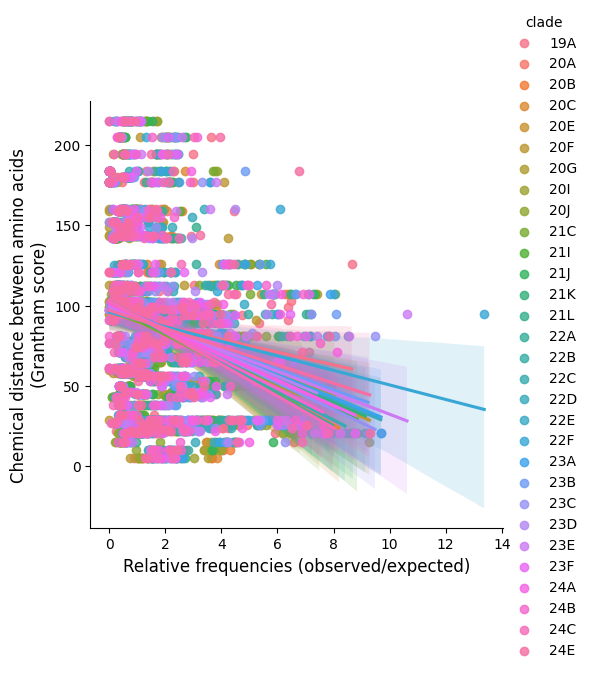

In [51]:
# fig 3b in https://link.springer.com/article/10.1186/gb-2003-4-11-r72
sns.lmplot(data=aa_subst_clades, y='granthamD', x='obs_relative_freq', hue='clade')
plt.xlabel('Relative frequencies (observed/expected)', fontsize=12)
plt.ylabel('Chemical distance between amino acids\n(Grantham score)', fontsize=12)
cor = np.array([pearsonr(gr.granthamD, gr.obs_relative_freq).correlation \
            for _, gr in aa_subst_clades.groupby('clade')])
cor, cor.mean()

Text(0.5, 0, 'Observed frequency of amino acid substitution')

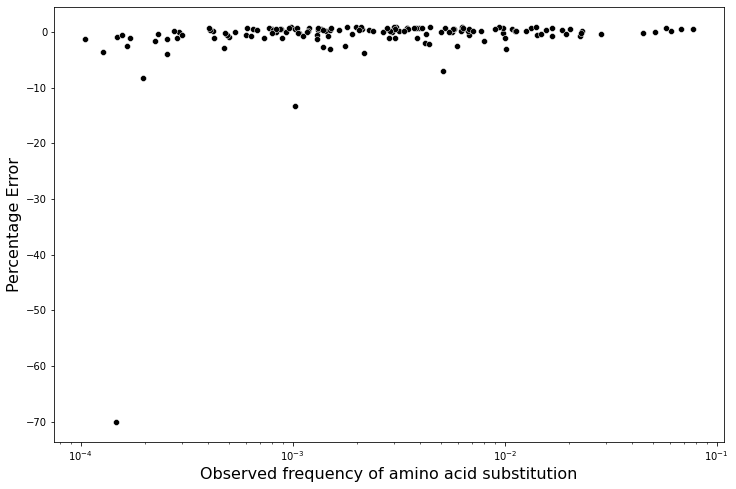

In [ ]:
# independence of frequency (useless in general)

plt.figure(figsize=(12, 8))
sns.scatterplot(aa_subst, x='nobs_freqs', y='mape', c='k')
plt.xscale('log')
# plt.yscale('log')
# plt.text(2.5e-2, -3, '${MAPE=const}$', {'size': 16})
plt.ylabel('Percentage Error', fontsize=16)
plt.xlabel('Observed frequency of amino acid substitution', fontsize=16)

## Fitting quality on mutations subsets

In [14]:
def plot_subst_freqs(aa_subst, title=''):
    aa_subst = aa_subst.copy()
    aa_subst['nobs_freqs_log'] = np.log10(aa_subst['nobs_freqs'])
    aa_subst['nexp_freqs_log'] = np.log10(aa_subst['nexp_freqs'])

    y_true, y_pred = aa_subst['nobs_freqs'], aa_subst['nexp_freqs']
    cor_res = pearsonr(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(r2)
    print(f"Pearson correlation: {cor_res.correlation:.3f} (p-value: {cor_res.pvalue:.3g})")

    plt.figure(figsize=(8, 8))
    ax = sns.regplot(aa_subst[aa_subst['nobs_freqs']>0], 
                color='blue', scatter_kws={'alpha':0.5, 's':50},
                y='nobs_freqs_log', x='nexp_freqs_log')

    ticks = np.linspace(-4, -1, 4)
    ticks_minor = np.log10(np.concat([
        np.linspace(10**-4, 10**-3, 10),
        np.linspace(10**-3, 10**-2, 10)[1:],
        np.linspace(10**-2, 10**-1, 10)[1:],
    ]))
    ax.set_xticks(ticks, ticks, size=14)
    ax.set_yticks(ticks, ticks, size=14)
    ax.set_xticks(ticks_minor, minor=True)
    ax.set_yticks(ticks_minor, minor=True)
    formatter = lambda x, pos: '10$^{' + str(int(x)) + '}$'
    ax.get_xaxis().set_major_formatter(formatter)
    ax.get_yaxis().set_major_formatter(formatter)
    # ax.get_xaxis().set_minor_locator(LogLocator(-10, 'auto'))
    # ax.get_xaxis().set_minor_locator(LogLocator())

    # plt.text(-2, -4., 
    #          f"r={cor_res.correlation:.1f} (p={cor_res.pvalue:.1g})", 
    #          fontsize=10)
    plt.plot([-4, -1], [-4, -1], color='black', linestyle='--',)
    plt.ylabel('Observed AA substitution frequencies', fontsize=16)
    plt.xlabel('Predicted AA substitution frequencies', fontsize=16)
    # plt.grid()
    # plt.ylabel('Наблюдаемые частоты замещений аминокислот', fontsize=14)
    # plt.xlabel('Ожидаемые частоты замещений аминокислот', fontsize=14)
    plt.title(title, fontsize=16)
    # plt.legend(title=f"spearmanr={cor_res.correlation:.2f} (p={cor_res.pvalue:.1g})", title_fontsize=14)
    plt.legend(title=f"$R^2$ = {r2:.2f}", title_fontsize=16)
    # plt.savefig('./figures/obs_exp_aa_freqs_20A.pdf')
    plt.show()

0.5539597345304178
Pearson correlation: 0.759 (p-value: 2.09e-29)


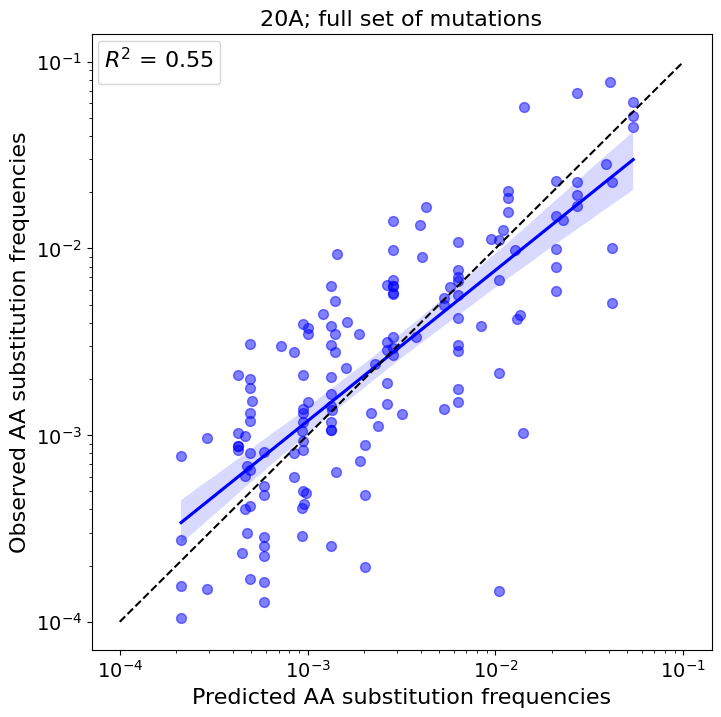

{'r2': 0.5539597345304177,
 'mape': 1.4046371897677377,
 'wape': 0.5819629950265685,
 'slope': np.float64(0.6905350982187564),
 'intercept': np.float64(0.002063099345208289),
 'spearman_corr': np.float64(0.7899138501932214),
 'spearman_p': np.float64(3.0461737388688496e-33),
 'pearson_corr': np.float64(0.7592835668146715),
 'pearson_corr_squared': np.float64(0.5765115348348097),
 'pearson_p': np.float64(2.0885611117155738e-29),
 'ks_stat': np.float64(0.12),
 'ks_p': np.float64(0.23078236357216822),
 'rmse': 0.00826780282155468,
 'log_likelihood': np.float64(-5.3689031336564685),
 'mut_count': np.float64(64430.99999999998),
 'mut_type_count': np.int64(149),
 'corr_chem_vs_rel_freq': np.float64(-0.22912635450463645),
 'corr_chem_vs_rel_freq_pval': np.float64(0.004796997466925358)}

In [24]:
obs_clade = obs[obs['clade'] == '20A']
exp_aa_subst, _ = prepare_exp_aa_subst(spectrum_20A)
aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, aa_freqs_total_dct)
plot_subst_freqs(aa_subst, '20A; full set of mutations', )
calc_metrics(aa_subst)

### Clades

In [41]:
metrics_total = []
aa_subst_total = []
for clade in tqdm.tqdm(clades_spectra.clade.unique(), desc='Clades'):
    spectrum_clade = clades_spectra[clades_spectra['clade'] == clade]
    exp_aa_subst, exp_aa_subst_matrix = prepare_exp_aa_subst(spectrum_clade, 'rate', 1)
    obs_clade = obs[obs['clade'] == clade].copy()

    # for total sites set
    aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, aa_freqs_total_dct)
    cur_metrics1 = calc_metrics(aa_subst)
    cur_metrics1['clade'] = clade
    cur_metrics1['branches'] = 'all'

    # for total sites set only terminal branches
    obs_clade_terminal = obs_clade.rename(columns={'count': 'count_all', 'count_terminal': 'count'})
    aa_subst = prepare_aa_subst(obs_clade_terminal, exp_aa_subst, aa_freqs_total_dct)
    cur_metrics2 = calc_metrics(aa_subst)
    cur_metrics2['clade'] = clade
    cur_metrics2['branches'] = 'terminal'

    # for total sites set only non-terminal branches
    obs_clade_nonterminal = obs_clade.rename(columns={'count': 'count_all', 'count_non_terminal': 'count'})
    aa_subst = prepare_aa_subst(obs_clade_nonterminal, exp_aa_subst, aa_freqs_total_dct)
    cur_metrics3 = calc_metrics(aa_subst)
    cur_metrics3['clade'] = clade
    cur_metrics3['branches'] = 'non-terminal'

    metrics_total.extend([cur_metrics1, cur_metrics2, cur_metrics3])

metrics_total_df = pd.DataFrame(metrics_total).set_index(['clade', 'branches'])
metrics_total_df.to_csv('data/fit_metrics_branches.csv', float_format='%g')

# aa_subst_total_df = pd.concat(aa_subst_total, ignore_index=True)
# aa_subst_total_df.to_csv('data/aa_subst_total_rates.csv', float_format='%g')


Clades: 100%|██████████| 24/24 [00:03<00:00,  6.98it/s]


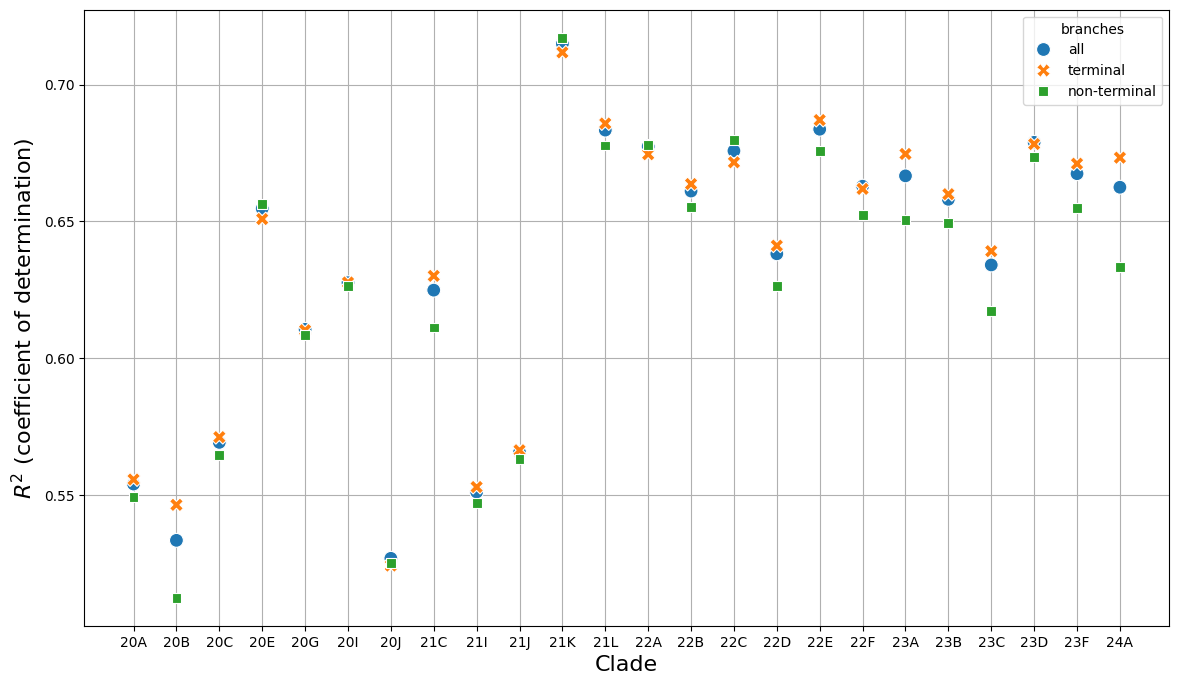

In [43]:
plt.figure(figsize=(14, 8))
ax = sns.scatterplot(data=metrics_total_df, hue='branches', y='r2', x='clade', style='branches', s=100)
plt.ylabel('$R^2$ (coefficient of determination)', fontsize=16)
plt.xlabel('Clade', fontsize=16)
ax.set_axisbelow(True)
plt.grid()

In [ ]:
# _1 = {x:'Early clades' for x in metrics_total_df.set_index('clade').loc[:'21J'].index.unique()}
# _2 = {x:'Late clades\n(Omicron+)' for x in metrics_total_df.set_index('clade').loc['21K':].index.unique()}

# _clade2label = {**_1, **_2}

In [47]:
metrics_total_df.reset_index(inplace=True)
metrics_total_df['time_period'] = metrics_total_df['clade'].map(_clade2label)

/tmp/ipykernel_108503/1096281969.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


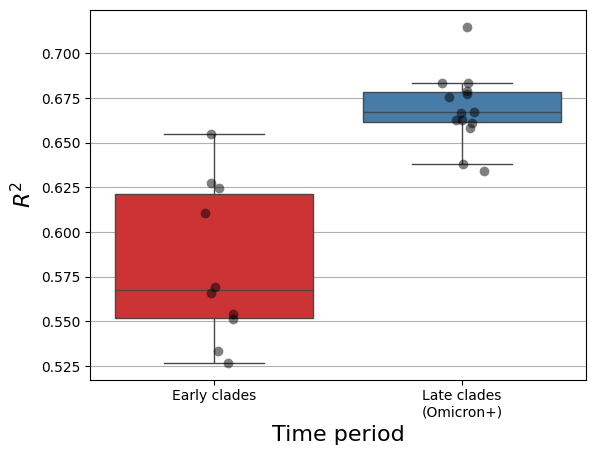

In [48]:
sns.stripplot(
    data=metrics_total_df.query('branches == "all"'), y='r2', x='time_period', 
    s=7, jitter=0.1, color='black', alpha=0.5,
)
sns.boxplot(
    data=metrics_total_df.query('branches == "all"'), y='r2', x='time_period', 
    palette='Set1', fliersize=0,
)
plt.ylabel('$R^2$', fontsize=16)
plt.xlabel('Time period', fontsize=16)
plt.grid(axis='y')

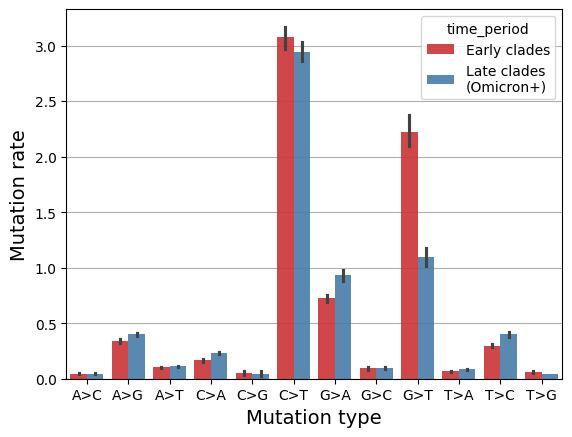

In [49]:
clades_spectra = pd.read_csv('./data/bloom_etal/rates_by_clade.csv').query('subset == "all"')
clades_spectra['time_period'] = clades_spectra['clade'].map(_clade2label)
clades_spectra['Mut'] = clades_spectra['mut_type'].str.replace('to', '>')
# _ = clades_spectra.groupby(['time_period', 'Mut'])['rate'].mean()
ax=sns.barplot(
    # _[_ > 0].reset_index(),
    clades_spectra,
    x='Mut', y='rate', hue='time_period',
    palette='Set1', alpha=0.9, hue_order=['Early clades', 'Late clades\n(Omicron+)'],
)
plt.ylabel('Mutation rate', fontsize=14)
plt.xlabel('Mutation type', fontsize=14)
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.show()

### Compare with random spectra

In [50]:
from utils import prepare_rnd_exp_aa_subst

metrics_total = []
for clade in tqdm.tqdm(clades_spectra.clade.unique(), desc='Clades'):
    obs_clade = obs[obs['clade'] == clade].copy()

    # neutral model
    spectrum_clade = clades_spectra[clades_spectra['clade'] == clade]
    exp_aa_subst, _ = prepare_exp_aa_subst(spectrum_clade, 'rate', 1)
    aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, aa_freqs_total_dct)
    cur_metrics = calc_metrics(aa_subst)
    cur_metrics['model'] = 'neutral'
    cur_metrics['clade'] = clade
    cur_metrics['replica'] = 1
    metrics_total.append(cur_metrics)

    # random model
    for i in range(1, 21):
        exp_aa_subst_rnd, _ = prepare_rnd_exp_aa_subst(1)
        aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst_rnd, aa_freqs_total_dct)
        cur_metrics = calc_metrics(aa_subst)
        cur_metrics['model'] = 'random'
        cur_metrics['clade'] = clade
        cur_metrics['replica'] = i
        metrics_total.append(cur_metrics)

metrics_total_df = pd.DataFrame(metrics_total).set_index(['model', 'clade', 'replica'])
metrics_total_df.to_csv('data/fit_metrics_rnd.csv', float_format='%g')

Clades: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


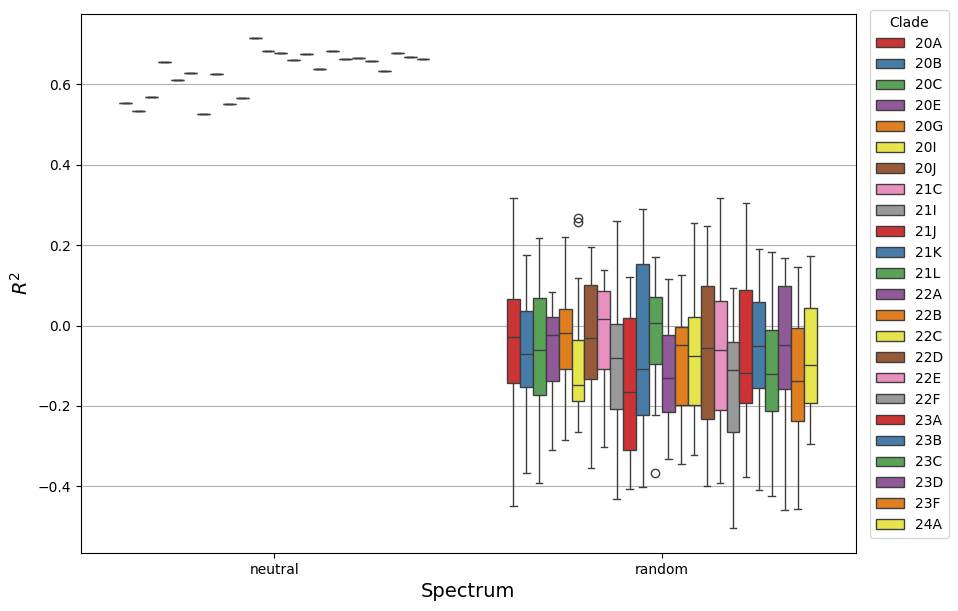

In [53]:
plt.figure(figsize=(10, 7))
ax = sns.boxplot(data=metrics_total_df.reset_index(), 
                y='r2', x='model', hue='clade',
                palette='Set1',
)
ax.set_xlabel('Spectrum', fontsize=14)
ax.set_ylabel('$R^2$', fontsize=14)
plt.legend(title='Clade', bbox_to_anchor=(1.01, 1.02), loc='upper left')
plt.grid(axis='y')
plt.savefig('./figures/fit_metrics_rnd.pdf')

### Codon positions

In [48]:
def prepare_exp_aa_subst_codons(spectrum: pd.DataFrame, rate_col='rate', gc=1, save_path=None, codon_pos='all'): 
    df_changes = collect_possible_changes(gc=gc)
    spectrum_dict = spectrum.set_index('Mut')[rate_col].to_dict()
    df_changes['rate'] = df_changes['sbs'].map(spectrum_dict)

    if codon_pos == 'all':
        df_changes_flt = df_changes.query('aa1 != "*" & aa2 != "*"')
    elif codon_pos == '12':
        df_changes_flt = df_changes.query('aa1 != "*" & aa2 != "*" & pic in [0, 1]')
    elif isinstance(codon_pos, int):
        pic=codon_pos - 1
        df_changes_flt = df_changes.query('aa1 != "*" & aa2 != "*" & pic == @pic')
    else:
        raise ValueError(f"Invalid codon_pos value: {codon_pos}. Allowed values are 'all', '12', 1, 2, or 3.")

    ## Calculate expected AA substitutions matrix
    exp_aa_subst = df_changes_flt.groupby(['aa1', 'aa2'])['rate'].sum().reset_index()
    
    if save_path:
        exp_aa_subst.to_csv(save_path, float_format='%g', index=False)
    exp_aa_subst_matrix = exp_aa_subst.pivot(index='aa1', columns='aa2', values='rate').fillna(0.)
    return exp_aa_subst, exp_aa_subst_matrix

In [57]:
obs_clade.codon_position.unique()

array(['2', '2;2', '1', '1;1', '3', '3;3'], dtype=object)

pos=1: $R^2$ = 0.62
pos=2: $R^2$ = 0.61
pos=3: $R^2$ = 0.43


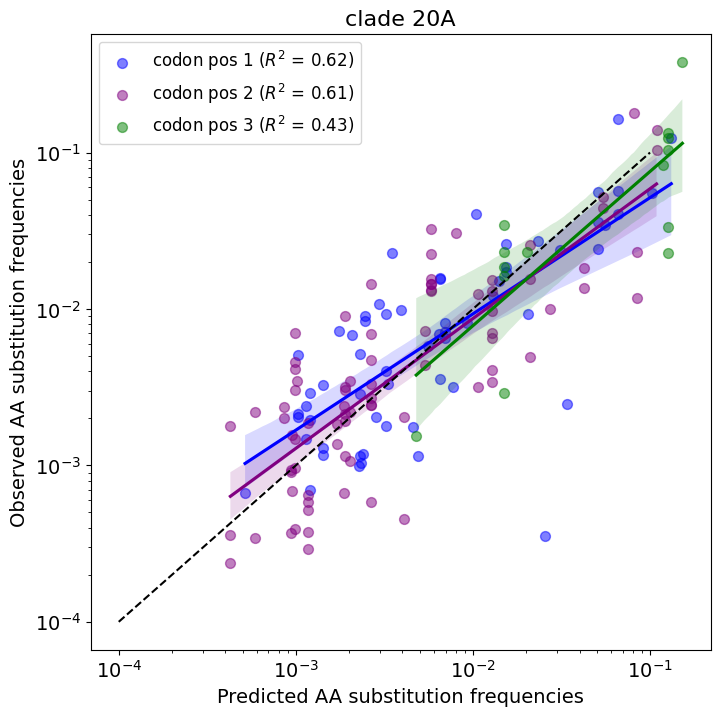

In [60]:
title = 'clade 20A'
obs_clade = obs[obs['clade'] == '20A']

_exp_aa_subst1 = prepare_exp_aa_subst_codons(spectrum_20A, codon_pos=1)[0]
_exp_aa_subst2 = prepare_exp_aa_subst_codons(spectrum_20A, codon_pos=2)[0]
_exp_aa_subst3 = prepare_exp_aa_subst_codons(spectrum_20A, codon_pos=3)[0]

obs_1 = obs_clade.query(f'codon_position == "1" | codon_position == "1;1"')
obs_2 = obs_clade.query(f'codon_position == "2" | codon_position == "2;2"')
obs_3 = obs_clade.query(f'codon_position == "3" | codon_position == "3;3"')

_aa_subst1 = prepare_aa_subst(obs_1, _exp_aa_subst1, aa_freqs_total_dct)
_aa_subst2 = prepare_aa_subst(obs_2, _exp_aa_subst2, aa_freqs_total_dct)
_aa_subst3 = prepare_aa_subst(obs_3, _exp_aa_subst3, aa_freqs_total_dct)

_aa_subst1['nobs_freqs_log'] = np.log10(_aa_subst1['nobs_freqs'])
_aa_subst1['nexp_freqs_log'] = np.log10(_aa_subst1['nexp_freqs'])
_aa_subst2['nobs_freqs_log'] = np.log10(_aa_subst2['nobs_freqs'])
_aa_subst2['nexp_freqs_log'] = np.log10(_aa_subst2['nexp_freqs'])
_aa_subst3['nobs_freqs_log'] = np.log10(_aa_subst3['nobs_freqs'])
_aa_subst3['nexp_freqs_log'] = np.log10(_aa_subst3['nexp_freqs'])

r2_1 = r2_score(_aa_subst1['nobs_freqs'], _aa_subst1['nexp_freqs'])
r2_2 = r2_score(_aa_subst2['nobs_freqs'], _aa_subst2['nexp_freqs'])
r2_3 = r2_score(_aa_subst3['nobs_freqs'], _aa_subst3['nexp_freqs'])
print(f"pos=1: $R^2$ = {r2_1:.2f}")
print(f"pos=2: $R^2$ = {r2_2:.2f}")
print(f"pos=3: $R^2$ = {r2_3:.2f}")

plt.figure(figsize=(8, 8))
sns.regplot(_aa_subst1[_aa_subst1['nobs_freqs']>0], 
            color='blue', scatter_kws={'alpha':0.5, 's':50},
            y='nobs_freqs_log', x='nexp_freqs_log', label=f'codon pos 1 ($R^2$ = {r2_1:.2f})')

sns.regplot(_aa_subst2[_aa_subst2['nobs_freqs']>0], 
            color='purple', scatter_kws={'alpha':0.5, 's':50},
            y='nobs_freqs_log', x='nexp_freqs_log', label=f'codon pos 2 ($R^2$ = {r2_2:.2f})')


ax = sns.regplot(_aa_subst3[_aa_subst3['nobs_freqs']>0], 
            color='green', scatter_kws={'alpha':0.5, 's':50},
            y='nobs_freqs_log', x='nexp_freqs_log', label=f'codon pos 3 ($R^2$ = {r2_3:.2f})')

ticks = np.linspace(-4, -1, 4)
ticks_minor = np.log10(np.concat([
    np.linspace(10**-4, 10**-3, 10),
    np.linspace(10**-3, 10**-2, 10)[1:],
    np.linspace(10**-2, 10**-1, 10)[1:],
]))
ax.set_xticks(ticks, ticks, size=14)
ax.set_yticks(ticks, ticks, size=14)
ax.set_xticks(ticks_minor, minor=True)
ax.set_yticks(ticks_minor, minor=True)
formatter = lambda x, pos: '10$^{' + str(int(x)) + '}$'
ax.get_xaxis().set_major_formatter(formatter)
ax.get_yaxis().set_major_formatter(formatter)
# ax.get_xaxis().set_minor_locator(LogLocator(-10, 'auto'))
# ax.get_xaxis().set_minor_locator(LogLocator())

# plt.text(-2, -4., 
#          f"r={r2_.correlation:.1f} (p={r2_.pvalue:.1g})", 
#          fontsize=10)
plt.plot([-4, -1], [-4, -1], color='black', linestyle='--',)
plt.ylabel('Observed AA substitution frequencies', fontsize=14)
plt.xlabel('Predicted AA substitution frequencies', fontsize=14)
plt.title(title, fontsize=16)
plt.legend(fontsize=12)
# plt.legend(title=f"spearmanr={r2_.correlation:.2f} (p={r2_.pvalue:.1g})", title_fontsize=14)
plt.savefig('./figures/obs_exp_aa_freqs_20A.pdf')
plt.show()

In [84]:
_d = []
for clade, obs_clade in obs.groupby('clade'):
    cur_ms = clades_spectra[clades_spectra['clade'] == clade].copy()
    cur_ms['rate'] /= cur_ms['rate'].sum()

    if len(cur_ms) == 0:
        continue

    _exp_aa_subst1 = prepare_exp_aa_subst_codons(cur_ms, codon_pos=1)[0]
    _exp_aa_subst2 = prepare_exp_aa_subst_codons(cur_ms, codon_pos=2)[0]
    _exp_aa_subst3 = prepare_exp_aa_subst_codons(cur_ms, codon_pos=3)[0]

    obs_1 = obs_clade.query(f'codon_position == "1" | codon_position == "1;1"')
    obs_2 = obs_clade.query(f'codon_position == "2" | codon_position == "2;2"')
    obs_3 = obs_clade.query(f'codon_position == "3" | codon_position == "3;3"')

    _aa_subst1 = prepare_aa_subst(obs_1, _exp_aa_subst1, aa_freqs_total_dct)
    _aa_subst2 = prepare_aa_subst(obs_2, _exp_aa_subst2, aa_freqs_total_dct)
    _aa_subst3 = prepare_aa_subst(obs_3, _exp_aa_subst3, aa_freqs_total_dct)

    m1 = calc_metrics(_aa_subst1)
    m2 = calc_metrics(_aa_subst2)
    m3 = calc_metrics(_aa_subst3)
    _d.append({
        'clade': clade,
        'pos1': m1['r2'],
        'pos2': m2['r2'],
        'pos3': m3['r2'],
    })
df_metrics = pd.DataFrame(_d)
df_metrics_long = df_metrics.set_index('clade')\
    .melt(var_name='position', value_name='r2', ignore_index=False).reset_index()
df_metrics_long.head()

clade position        r2
0   20A     pos1  0.619186
1   20B     pos1  0.629596
2   20C     pos1  0.628102
3   20E     pos1  0.704365
4   20G     pos1  0.614804

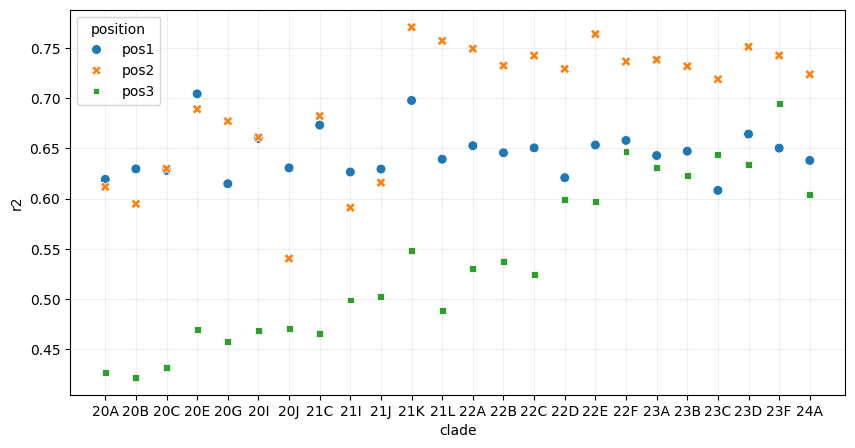

In [90]:
plt.figure(figsize=(10, 5))
ax = sns.scatterplot(df_metrics_long, x='clade', y='r2', hue='position', style='position', s=50)
plt.grid(alpha=.2)
ax.set_axisbelow(True)

### separate on genes

In [ ]:
metrics_data = []
for (cur_clade, cur_protein), cur_obs in obs.groupby(['clade', 'protein']):
    if cur_clade not in clades_spectra['clade'].values:
        continue
    spectrum_clade = clades_spectra[clades_spectra['clade'] == cur_clade]
    cur_exp_aa_subst, _ = prepare_exp_aa_subst(spectrum_clade, 'rate', 1)

    cur_aa_content = aa_freqs_df.loc[cur_protein].rename(index=amino_acid_codes).to_dict()

    cur_obs_flt = cur_obs[(cur_obs.aa1 != '*') & (cur_obs.aa2 != '*')]
    aa_subst = prepare_aa_subst(cur_obs_flt, cur_exp_aa_subst, cur_aa_content)

    cur_metrics = calc_metrics(aa_subst)
    cur_metrics['clade'] = cur_clade
    cur_metrics['protein'] = cur_protein
    metrics_data.append(cur_metrics)

metrics_data = pd.DataFrame(metrics_data).groupby(['clade', 'protein']).mean().reset_index()
metrics_data['time_period']  = metrics_data['clade'].map(_clade2label)
metrics_data['protein_size'] = metrics_data['protein'].map(aa_freqs_df.sum(1).to_dict())
metrics_data

clade       protein        r2      mape      wape     slope  intercept  \
0     20A             E  0.371716  1.039506  0.709010  0.307516   0.004617   
1     20A             M  0.156468  2.122364  0.844577  0.296904   0.004687   
2     20A             N  0.319434  1.678265  0.755365  0.408088   0.003946   
3     20A         ORF10  0.504057  0.692208  0.547901  0.424706   0.003835   
4     20A  ORF1a;ORF1ab  0.501862  2.527333  0.685590  0.574784   0.002835   
..    ...           ...       ...       ...       ...       ...        ...   
283   24A          ORF6  0.116197  0.764913  0.639325  0.340048   0.004400   
284   24A         ORF7a  0.478540  1.222643  0.632450  0.484856   0.003434   
285   24A         ORF7b  0.297095  0.691293  0.620002  0.356036   0.004293   
286   24A          ORF8  0.530623  1.110309  0.598047  0.653937   0.002307   
287   24A             S  0.150795  1.666304  0.762340  0.640841   0.002394   

     spearman_corr    spearman_p  pearson_corr  pearson_corr_squared  \
0         0.529720  3.166222e-12      0.623422              0.388655   
1         0.655262  9.251162e-20      0.448959              0.201564   
2         0.602832  3.286698e-16      0.579013              0.335256   
3         0.414974  1.292551e-07      0.722696              0.522289   
4         0.757632  3.238773e-29      0.714193              0.510072   
..             ...           ...           ...                   ...   
283       0.243469  2.680013e-03      0.452835              0.205059   
284       0.617064  4.152354e-17      0.691824              0.478621   
285       0.209208  1.018963e-02      0.552690              0.305467   
286       0.635189  2.547006e-18      0.741746              0.550187   
287       0.634487  2.847532e-18      0.602616              0.363146   

        pearson_p   ks_stat          ks_p      rmse  log_likelihood  \
0    1.592386e-17  0.593333  7.588478e-25  0.018092       -4.875340   
1    8.295369e-09  0.326667  1.756439e-07  0.015636       -5.405978   
2    8.399269e-15  0.206667  3.220729e-03  0.013178       -5.353119   
3    1.632055e-25  0.580000  1.105089e-23  0.013492       -4.906098   
4    1.069847e-24  0.146667  7.930977e-02  0.009873       -5.320390   
..            ...       ...           ...       ...             ...   
283  5.947207e-09  0.520000  7.237717e-19  0.014488       -5.756893   
284  1.102395e-22  0.226667  8.634332e-04  0.011924       -5.249714   
285  2.251787e-13  0.580000  1.105089e-23  0.015061       -5.386827   
286  1.852900e-27  0.233333  5.413960e-04  0.008993       -5.445576   
287  3.388835e-16  0.093333  5.321869e-01  0.010028       -5.784955   

     mut_count  mut_type_count  corr_chem_vs_rel_freq  \
0        543.0            61.0              -0.066598   
1       1073.0           101.0              -0.232819   
2       4340.0           126.0              -0.061189   
3        467.0            63.0              -0.047838   
4      26469.0           146.0              -0.220376   
..         ...             ...                    ...   
283      407.0            72.0              -0.131603   
284     1919.0           116.0              -0.148203   
285      394.0            63.0              -0.022193   
286     1799.0           115.0               0.167531   
287    11659.0           144.0              -0.120396   

     corr_chem_vs_rel_freq_pval  
0                      0.418092  
1                      0.004143  
2                      0.456973  
3                      0.561021  
4                      0.006731  
..                          ...  
283                    0.108427  
284                    0.070306  
285                    0.787489  
286                    0.040445  
287                    0.142227  

[288 rows x 20 columns]

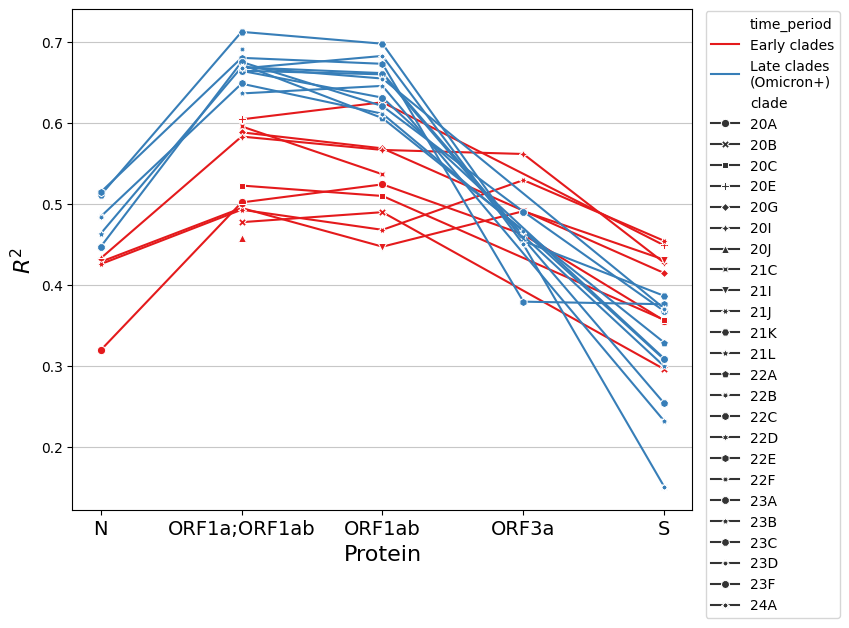

In [95]:
_ = metrics_data.query('mut_count > 4000 & protein_size > 250')
plt.figure(figsize=(8, 6.5))
ax = sns.lineplot(
    _, x='protein', y='r2', style='clade', hue='time_period', 
    markers=True, dashes=False, palette='Set1',)
plt.legend(bbox_to_anchor=(1.01, 1.01), loc='upper left')
plt.ylabel('$R^2$', fontsize=16)
plt.xlabel('Protein', fontsize=16)
plt.grid(axis='y', alpha=0.7)
plt.xticks(fontsize=14)
plt.show()

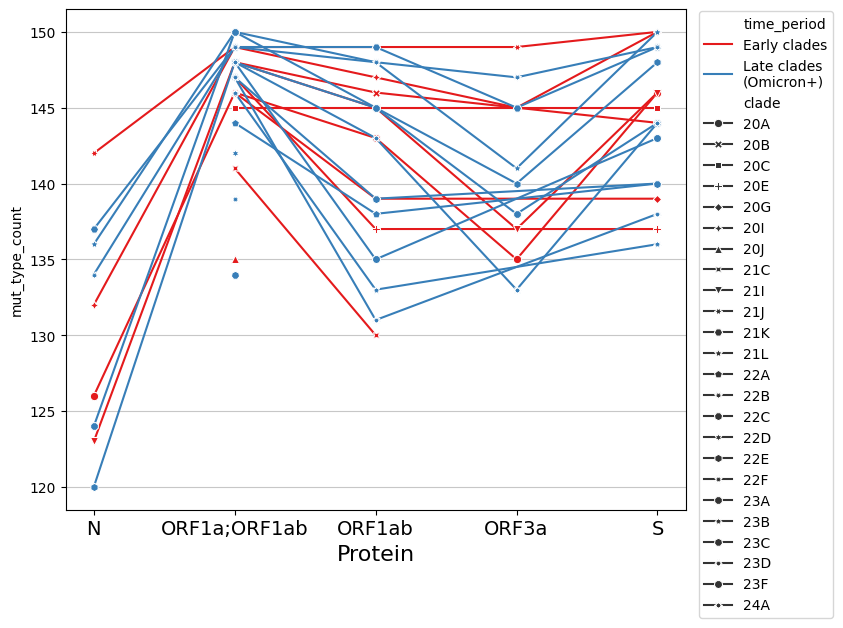

In [96]:
_ = metrics_data[metrics_data.protein.isin(['ORF3a', 'S', 'N', 'ORF1ab', 'ORF1a;ORF1ab'])]\
    .query('mut_count > 4000')
plt.figure(figsize=(8, 6.5))
ax = sns.lineplot(
    _, x='protein', y='mut_type_count', style='clade', hue='time_period', 
    markers=True, dashes=False, palette='Set1',)
plt.legend(bbox_to_anchor=(1.01, 1.01), loc='upper left')
# plt.ylabel('$R^2$', fontsize=16)
plt.xlabel('Protein', fontsize=16)
plt.grid(axis='y', alpha=0.7)
plt.xticks(fontsize=14)
plt.show()


<Axes: xlabel='clade', ylabel='r2'>

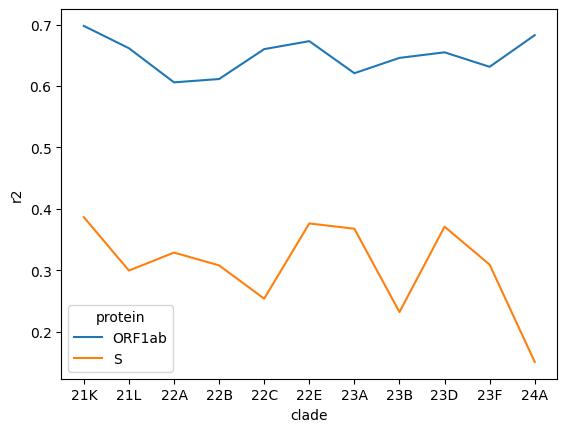

In [97]:
# no significant tendensies
_ = metrics_data.query('(protein == "S" | protein == "ORF1ab") & mut_count > 4000 & time_period != "Early clades"')
sns.lineplot(_, x='clade', y='r2', hue='protein')

Text(0.5, 28.999999999999964, 'Mutations count in clade')

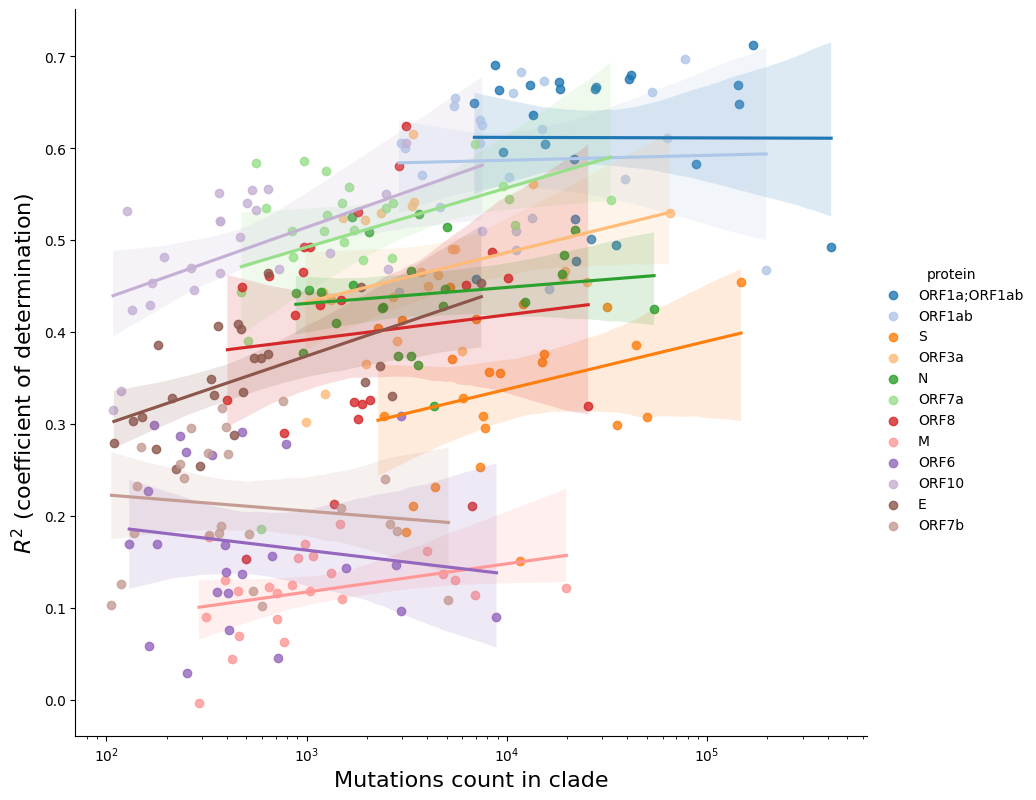

In [100]:
sns.lmplot(metrics_data, y='r2', x='mut_count', hue='protein', 
           hue_order=metrics_data.groupby('protein')['mut_count'].mean().sort_values(ascending=False).index,
           height=8, aspect=1.1, logx=True, palette='tab20')
plt.xscale('log')
plt.ylabel('$R^2$ (coefficient of determination)', fontsize=16)
plt.xlabel('Mutations count in clade', fontsize=16)

### Check now on ORF1ab proteins

In [101]:
aamut_fitness = pd.read_csv('./data/bloom_etal/aamut_fitness_by_clade.csv')
aamut_fitness['aa1'] = aamut_fitness['aa_mutation'].str[0]
aamut_fitness['aa2'] = aamut_fitness['aa_mutation'].str[-1]
aamut_fitness_ns = aamut_fitness.query('aa1 != aa2 & aa1 != "*" & aa2 != "*"')
aamut_fitness

clade  gene clade_founder_aa mutant_aa  aa_site aa_mutation  \
0         20A     E                A         A       22        A22A   
1         20A     E                A         A       32        A32A   
2         20A     E                A         A       36        A36A   
3         20A     E                A         A       41        A41A   
4         20A     E                A         D       22        A22D   
...       ...   ...              ...       ...      ...         ...   
2893365   24A  nsp1                Y         F       97        Y97F   
2893366   24A  nsp1                Y         H       97        Y97H   
2893367   24A  nsp1                Y         N       97        Y97N   
2893368   24A  nsp1                Y         S       97        Y97S   
2893369   24A  nsp1                Y         Y       97        Y97Y   

         expected_count  actual_count  count_terminal  count_non_terminal  \
0               1.87400             2               0                   2   
1              14.74200            20              14                   6   
2              14.48000             1               0                   1   
3              14.48000             3               2                   1   
4               0.67725             0               0                   0   
...                 ...           ...             ...                 ...   
2893365         0.77908             0               0                   0   
2893366         2.17910             0               0                   0   
2893367         0.48805             0               0                   0   
2893368         0.20445             0               0                   0   
2893369        18.50500            27              20                   7   

         mean_log_size  subset_of_ORF1ab  delta_fitness aa1 aa2  
0              2.41010             False       0.051727   A   A  
1              0.41743             False       0.296350   A   A  
2              1.94590             False      -2.301200   A   A  
3              0.82833             False      -1.453900   A   A  
4              0.00000             False      -0.856330   A   D  
...                ...               ...            ...  ..  ..  
2893365        0.00000              True      -0.939290   Y   F  
2893366        0.00000              True      -1.678600   Y   H  
2893367        0.00000              True      -0.681130   Y   N  
2893368        0.00000              True      -0.342810   Y   S  
2893369        0.34553              True       0.369480   Y   Y  

[2893370 rows x 15 columns]

In [102]:
metrics_data2 = []
for (cur_clade, cur_protein), cur_obs in aamut_fitness.query('subset_of_ORF1ab == True')\
        .rename(columns={'actual_count': 'count'}).groupby(['clade', 'gene']):
    if cur_clade not in clades_spectra['clade'].values:
        continue
    spectrum_clade = clades_spectra[clades_spectra['clade'] == cur_clade]
    cur_exp_aa_subst, _ = prepare_exp_aa_subst(spectrum_clade, 'rate', 1)

    cur_aa_content = aa_freqs_df_orf1ab.loc[cur_protein].rename(index=amino_acid_codes).to_dict()

    cur_obs_flt = cur_obs[(cur_obs.aa1 != '*') & (cur_obs.aa2 != '*')]
    aa_subst = prepare_aa_subst(cur_obs_flt, cur_exp_aa_subst, cur_aa_content)

    cur_metrics = calc_metrics(aa_subst)
    cur_metrics['clade'] = cur_clade
    cur_metrics['protein'] = cur_protein
    metrics_data2.append(cur_metrics)

metrics_data2 = pd.DataFrame(metrics_data2).groupby(['clade', 'protein']).mean().reset_index()
metrics_data2['time_period']  = metrics_data2['clade'].map(_clade2label)
metrics_data2['protein_size'] = metrics_data2['protein'].map(aa_freqs_df_orf1ab.sum(1).to_dict())
metrics_data2

clade       protein        r2      mape      wape     slope  intercept  \
0     20A          nsp1  0.098082  1.299458  0.870677  0.338603   0.004409   
1     20A         nsp10  0.300892  1.470466  0.809886  0.352992   0.004313   
2     20A  nsp12 (RdRp)  0.406790  1.457408  0.703233  0.529994   0.003133   
3     20A         nsp13  0.423181  2.229857  0.675638  0.451433   0.003657   
4     20A         nsp14  0.438659  2.055602  0.662436  0.468886   0.003541   
..    ...           ...       ...       ...       ...       ...        ...   
355   24A   nsp5 (Mpro)  0.232853  1.974763  0.783681  0.242160   0.005052   
356   24A          nsp6  0.322991  1.490114  0.761351  0.327373   0.004484   
357   24A          nsp7  0.208508  0.802231  0.669496  0.289685   0.004735   
358   24A          nsp8  0.315783  1.100418  0.766346  0.280921   0.004794   
359   24A          nsp9  0.376130  0.927955  0.728765  0.334424   0.004437   

     spearman_corr    spearman_p  pearson_corr  ...   ks_stat          ks_p  \
0         0.534138  1.933891e-12      0.444943  ...  0.386667  2.176881e-10   
1         0.447285  9.565347e-09      0.554610  ...  0.486667  1.799621e-16   
2         0.706998  4.982474e-24      0.655766  ...  0.220000  1.357878e-03   
3         0.665718  1.486164e-20      0.651801  ...  0.273333  2.445506e-05   
4         0.674376  3.089473e-21      0.663694  ...  0.246667  2.040625e-04   
..             ...           ...           ...  ...       ...           ...   
355       0.589965  1.956153e-15      0.482905  ...  0.386667  2.176881e-10   
356       0.561419  7.813735e-14      0.568373  ...  0.373333  1.072155e-09   
357       0.261208  1.243906e-03      0.475685  ...  0.660000  3.254808e-31   
358       0.480848  4.725946e-10      0.566324  ...  0.506667  6.934381e-18   
359       0.361342  5.547211e-06      0.618120  ...  0.600000  1.928738e-25   

         rmse  log_likelihood  mut_count  mut_type_count  \
0    0.014050       -5.608787     1186.0            92.0   
1    0.014790       -5.445867      500.0            77.0   
2    0.010729       -5.352490     3519.0           123.0   
3    0.012346       -5.182096     3332.0           117.0   
4    0.011940       -5.183488     2871.0           125.0   
..        ...             ...        ...             ...   
355  0.020213       -5.361394     1238.0            92.0   
356  0.016532       -5.188467     1330.0            94.0   
357  0.016906       -5.521615      339.0            51.0   
358  0.019298       -5.067957      917.0            74.0   
359  0.016895       -5.257563      492.0            60.0   

     corr_chem_vs_rel_freq  corr_chem_vs_rel_freq_pval  \
0                -0.125167                    0.126968   
1                -0.137309                    0.093825   
2                -0.305540                    0.000143   
3                -0.279700                    0.000527   
4                -0.207700                    0.010760   
..                     ...                         ...   
355              -0.084524                    0.303768   
356              -0.222199                    0.006279   
357              -0.089014                    0.278710   
358              -0.246488                    0.002361   
359              -0.197443                    0.015442   

                 time_period  protein_size  
0               Early clades           180  
1               Early clades           139  
2               Early clades           932  
3               Early clades           601  
4               Early clades           527  
..                       ...           ...  
355  Late clades\n(Omicron+)           306  
356  Late clades\n(Omicron+)           290  
357  Late clades\n(Omicron+)            83  
358  Late clades\n(Omicron+)           198  
359  Late clades\n(Omicron+)           113  

[360 rows x 22 columns]

In [110]:
metrics_data3 = []
for (cur_clade, cur_protein), cur_obs in aamut_fitness.query('subset_of_ORF1ab == False')\
        .rename(columns={'actual_count': 'count'}).groupby(['clade', 'gene']):
    if cur_clade not in clades_spectra['clade'].values:
        continue
    spectrum_clade = clades_spectra[clades_spectra['clade'] == cur_clade]
    cur_exp_aa_subst, _ = prepare_exp_aa_subst(spectrum_clade, 'rate', 1)

    if cur_protein == 'ORF9b':
        continue
    cur_aa_content = aa_freqs_df.loc[cur_protein].rename(index=amino_acid_codes).to_dict()

    cur_obs_flt = cur_obs[(cur_obs.aa1 != '*') & (cur_obs.aa2 != '*')]
    aa_subst = prepare_aa_subst(cur_obs_flt, cur_exp_aa_subst, cur_aa_content)

    cur_metrics = calc_metrics(aa_subst)
    cur_metrics['clade'] = cur_clade
    cur_metrics['protein'] = cur_protein
    metrics_data3.append(cur_metrics)

metrics_data3 = pd.DataFrame(metrics_data3).groupby(['clade', 'protein']).mean().reset_index()
metrics_data3['time_period']  = metrics_data3['clade'].map(_clade2label)
metrics_data3['protein_size'] = metrics_data3['protein'].map(aa_freqs_df.sum(1).to_dict())
metrics_data3

clade protein        r2      mape      wape     slope  intercept  \
0     20A       E  0.371264  1.058646  0.709295  0.305054   0.004633   
1     20A       M  0.151670  2.095201  0.854288  0.290374   0.004731   
2     20A       N  0.430019  1.537318  0.657325  0.477488   0.003483   
3     20A   ORF10  0.503359  0.685663  0.548716  0.417067   0.003886   
4     20A  ORF1ab  0.527153  1.830942  0.660767  0.590086   0.002733   
..    ...     ...       ...       ...       ...       ...        ...   
259   24A    ORF6  0.119110  0.761637  0.638568  0.338937   0.004407   
260   24A   ORF7a  0.480256  1.212433  0.628503  0.483168   0.003446   
261   24A   ORF7b  0.300487  0.703329  0.624007  0.352592   0.004316   
262   24A    ORF8  0.535064  1.023749  0.583160  0.645887   0.002361   
263   24A       S  0.176699  1.555629  0.757763  0.636606   0.002423   

     spearman_corr    spearman_p  pearson_corr  ...   ks_stat          ks_p  \
0         0.537263  1.358761e-12      0.624194  ...  0.600000  1.928738e-25   
1         0.656990  6.873028e-20      0.443292  ...  0.326667  1.756439e-07   
2         0.709355  3.025832e-24      0.659023  ...  0.246667  2.040625e-04   
3         0.422678  7.119886e-08      0.725170  ...  0.593333  7.588478e-25   
4         0.777813  1.180675e-31      0.730218  ...  0.133333  1.390622e-01   
..             ...           ...           ...  ...       ...           ...   
259       0.245469  2.464399e-03      0.453424  ...  0.520000  7.237717e-19   
260       0.617916  3.656327e-17      0.693017  ...  0.226667  8.634332e-04   
261       0.208050  1.062543e-02      0.554252  ...  0.593333  7.588478e-25   
262       0.615526  5.219231e-17      0.742492  ...  0.246667  2.040625e-04   
263       0.636474  2.075016e-18      0.607944  ...  0.093333  5.321869e-01   

         rmse  log_likelihood  mut_count  mut_type_count  \
0    0.018267       -4.856139      538.0            60.0   
1    0.015831       -5.405288     1054.0           101.0   
2    0.011731       -5.208611     5188.0           120.0   
3    0.013796       -4.860284      454.0            61.0   
4    0.009580       -5.283857    38877.0           147.0   
..        ...             ...        ...             ...   
259  0.014530       -5.750387      404.0            72.0   
260  0.011967       -5.242409     1907.0           116.0   
261  0.015215       -5.367118      390.0            61.0   
262  0.009071       -5.429621     1760.0           113.0   
263  0.010028       -5.759022    11408.0           143.0   

     corr_chem_vs_rel_freq  corr_chem_vs_rel_freq_pval  \
0                -0.047704                    0.562117   
1                -0.235193                    0.003765   
2                -0.176519                    0.030710   
3                -0.049297                    0.549120   
4                -0.244098                    0.002610   
..                     ...                         ...   
259              -0.138471                    0.091052   
260              -0.145978                    0.074673   
261              -0.019693                    0.810953   
262               0.162566                    0.046856   
263              -0.120200                    0.142880   

                 time_period  protein_size  
0               Early clades            75  
1               Early clades           222  
2               Early clades           419  
3               Early clades            38  
4               Early clades          2695  
..                       ...           ...  
259  Late clades\n(Omicron+)            61  
260  Late clades\n(Omicron+)           121  
261  Late clades\n(Omicron+)            43  
262  Late clades\n(Omicron+)           121  
263  Late clades\n(Omicron+)          1273  

[264 rows x 22 columns]

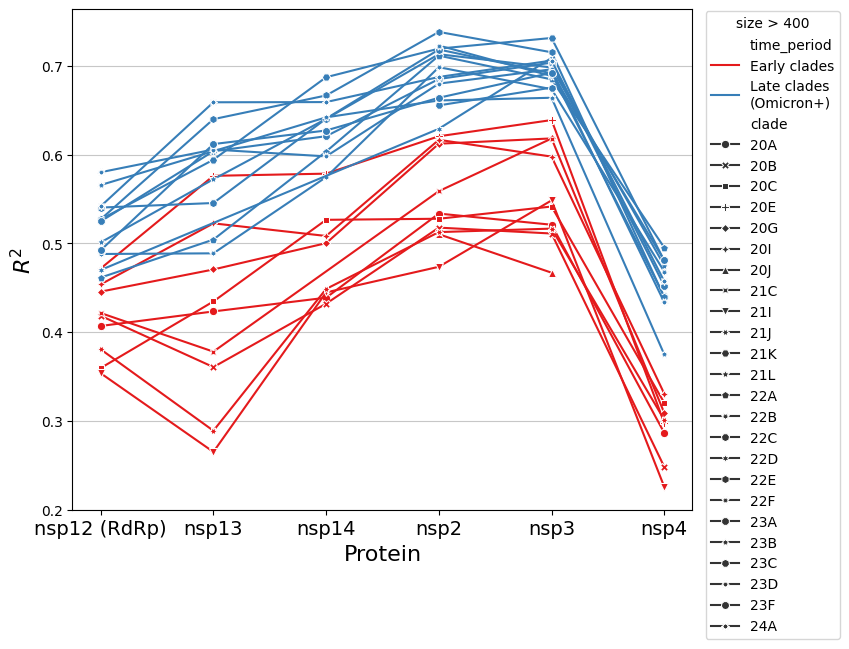

In [103]:
_ = metrics_data2.query('mut_count > 1000 & protein_size > 400')
plt.figure(figsize=(8, 6.5))
ax = sns.lineplot(
    _, x='protein', y='r2', style='clade', hue='time_period', 
    markers=True, dashes=False, palette='Set1',)
plt.legend(title='size > 400', bbox_to_anchor=(1.01, 1.01), loc='upper left')
plt.ylabel('$R^2$', fontsize=16)
plt.xlabel('Protein', fontsize=16)
plt.grid(axis='y', alpha=0.7)
plt.xticks(fontsize=14)
plt.show()

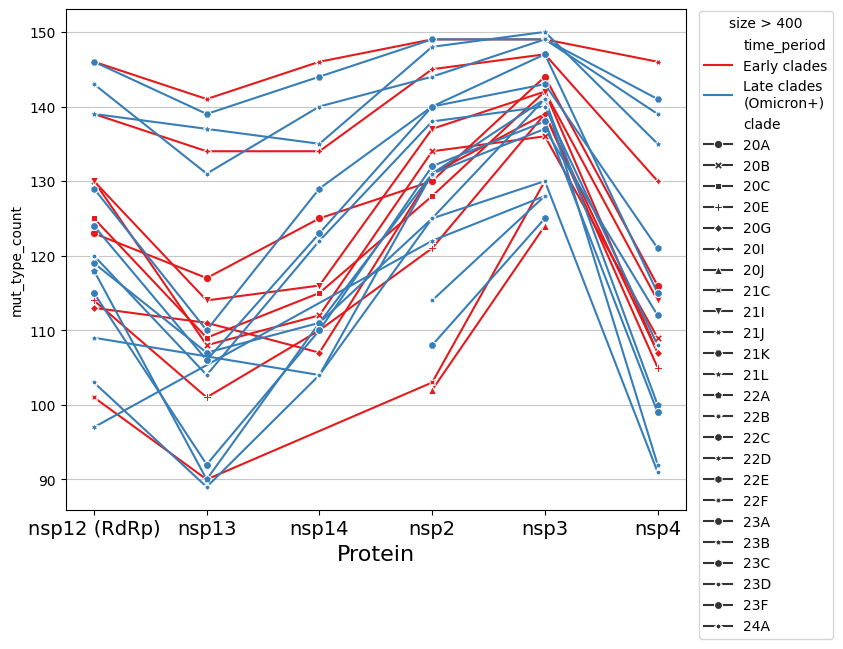

In [ ]:
_ = metrics_data2.query('mut_count > 1000 & protein_size > 400')
plt.figure(figsize=(8, 6.5))
ax = sns.lineplot(
    _, x='protein', y='mut_type_count', style='clade', hue='time_period', 
    markers=True, dashes=False, palette='Set1',)
plt.legend(title='size > 400', bbox_to_anchor=(1.01, 1.01), loc='upper left')
plt.xlabel('Protein', fontsize=16)
plt.grid(axis='y', alpha=0.7)
plt.xticks(fontsize=14)
plt.show()

In [129]:
metrics_data_tot = pd.concat([metrics_data3.query('200 < protein_size < 2000'), 
                              metrics_data2.query('200 < protein_size < 2000')], ignore_index=True)

protein
nsp2             24
nsp3             24
S                24
N                24
ORF3a            23
nsp12\n(RdRp)    21
nsp14            19
nsp13            19
nsp4             19
nsp15            16
nsp6             15
nsp5\n(Mpro)     14
nsp16            14
M                10
Name: count, dtype: int64


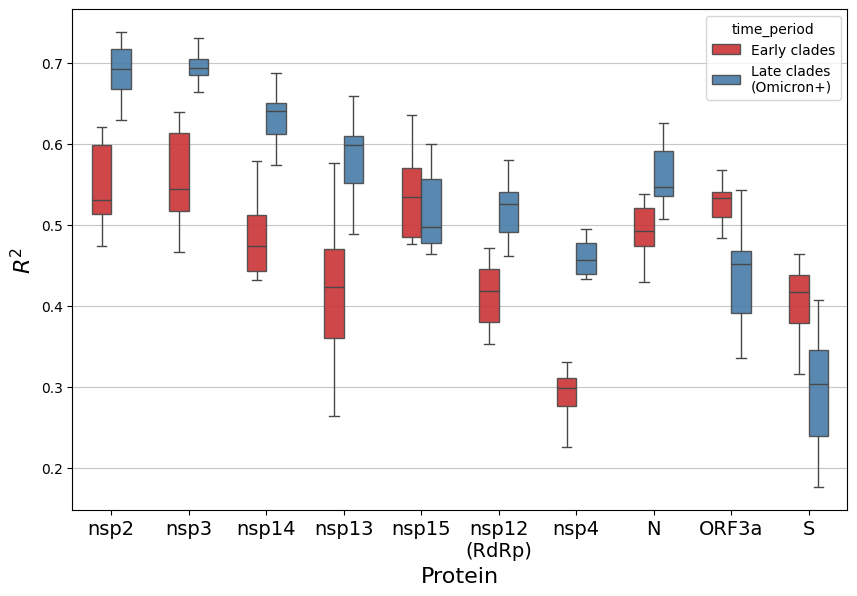

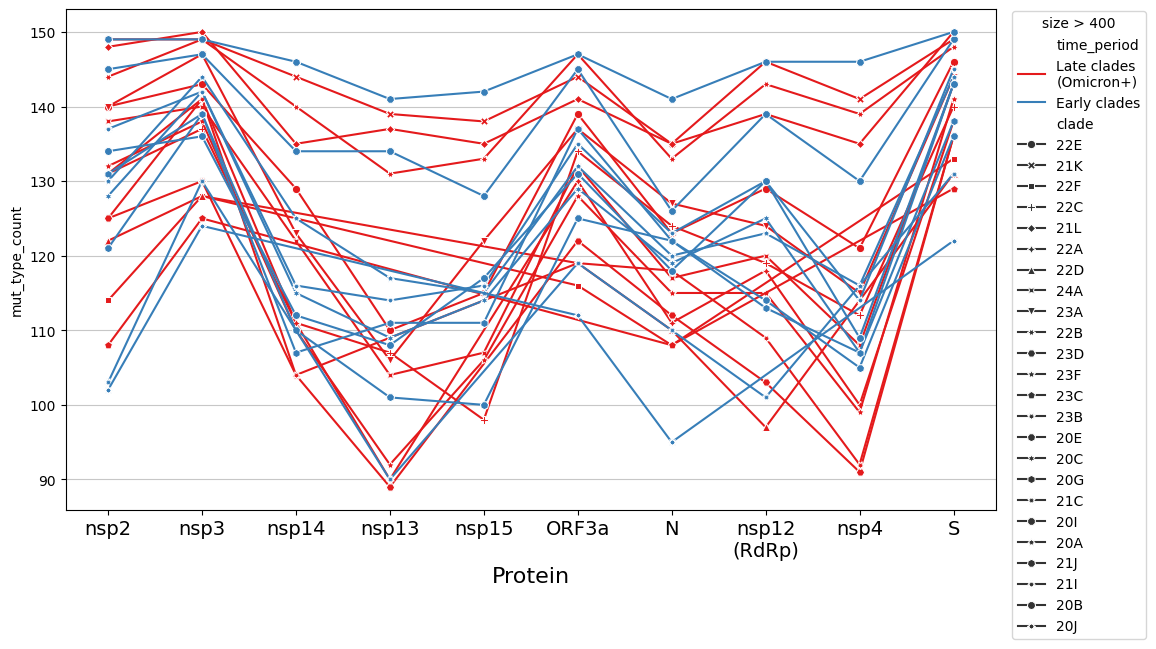

In [140]:
_ = metrics_data_tot.query('mut_count > 1000').sort_values('r2', ascending=False)
_['protein'] = _['protein'].replace({'nsp12 (RdRp)': 'nsp12\n(RdRp)', 'nsp5 (Mpro)': 'nsp5\n(Mpro)',})
print(_.protein.value_counts())
_ = _[_['protein'].isin(_.protein.value_counts().index[:10])]
prot_order = ['nsp2', 'nsp3', 'nsp14', 'nsp13', 'nsp15', 'nsp12\n(RdRp)', 'nsp4', 'N', 'ORF3a',  'S']

plt.figure(figsize=(10, 6.5))
# ax = sns.lineplot(
#     _, x='protein', y='r2', style='clade', hue='time_period', 
#     markers=True, dashes=False, palette='Set1',)
ax = sns.boxplot(
    _, x='protein', y='r2', hue='time_period', width=.5, fliersize=0,
    palette='Set1', legend=True, boxprops=dict(alpha=.9), 
    hue_order=['Early clades', 'Late clades\n(Omicron+)'],
    order=prot_order,
)

# plt.legend(title='size > 400', bbox_to_anchor=(1.01, 1.01), loc='upper left')
plt.ylabel('$R^2$', fontsize=16)
plt.xlabel('Protein', fontsize=16)
plt.grid(axis='y', alpha=0.7)
plt.xticks(fontsize=14)
plt.show()

plt.figure(figsize=(12, 6.5))
ax = sns.lineplot(
    _, x='protein', y='mut_type_count', style='clade', hue='time_period', 
    markers=True, dashes=False, palette='Set1')
plt.legend(title='size > 400', bbox_to_anchor=(1.01, 1.01), loc='upper left')
plt.xlabel('Protein', fontsize=16)
plt.grid(axis='y', alpha=0.7)
plt.xticks(fontsize=14)
plt.show()

### How many mutations required for unbiased result?

In [ ]:
# long (2 min)

sdata_full = []
for (cur_clade, ), obs_clade in obs.groupby(['clade']):
    if cur_clade not in clades_spectra['clade'].values:
        continue
    spectrum_clade = clades_spectra[clades_spectra['clade'] == cur_clade]
    cur_exp_aa_subst, _ = prepare_exp_aa_subst(spectrum_clade, 'rate', 1)
    
    obs_clade = obs_clade[(obs_clade.aa1 != '*') & (obs_clade.aa2 != '*')]

    exploded = []
    for _, x in obs_clade[['aa1', 'aa2', 'count']].iterrows():
        for _ in range(x['count']):
            exploded.append(x)
    exploded = pd.DataFrame(exploded).reset_index(drop=True)
    exploded['count'] = 1

    sdata = []
    for n in np.logspace(2, np.log10(len(exploded)-10), 100).astype(int):
        cur_sample = exploded.sample(n, replace=False)
        _aa_subst = prepare_aa_subst(cur_sample, cur_exp_aa_subst, aa_freqs_total_dct)
        cur_met = calc_metrics(_aa_subst)
        cor_res = spearmanr(_aa_subst['nobs_freqs'], _aa_subst['nexp_freqs'])
        sdata.append([n, cur_met['pearson_corr'], cur_met['r2']])

    sdata = pd.DataFrame(sdata, columns=['n', 'cor', 'r2']).assign(clade=cur_clade)
    sdata_full.append(sdata)

sdata_full_df = pd.concat(sdata_full)
sdata_full_df

n       cor        r2 clade
0     100  0.542003  0.226880   20A
1     106  0.664179  0.401669   20A
2     113  0.571583  0.264192   20A
3     121  0.662687  0.405904   20A
4     129  0.604632  0.355105   20A
..    ...       ...       ...   ...
95  49966  0.826435  0.666484   24A
96  53344  0.825043  0.664777   24A
97  56950  0.823638  0.661844   24A
98  60800  0.823369  0.661938   24A
99  64909  0.823548  0.662486   24A

[2400 rows x 4 columns]

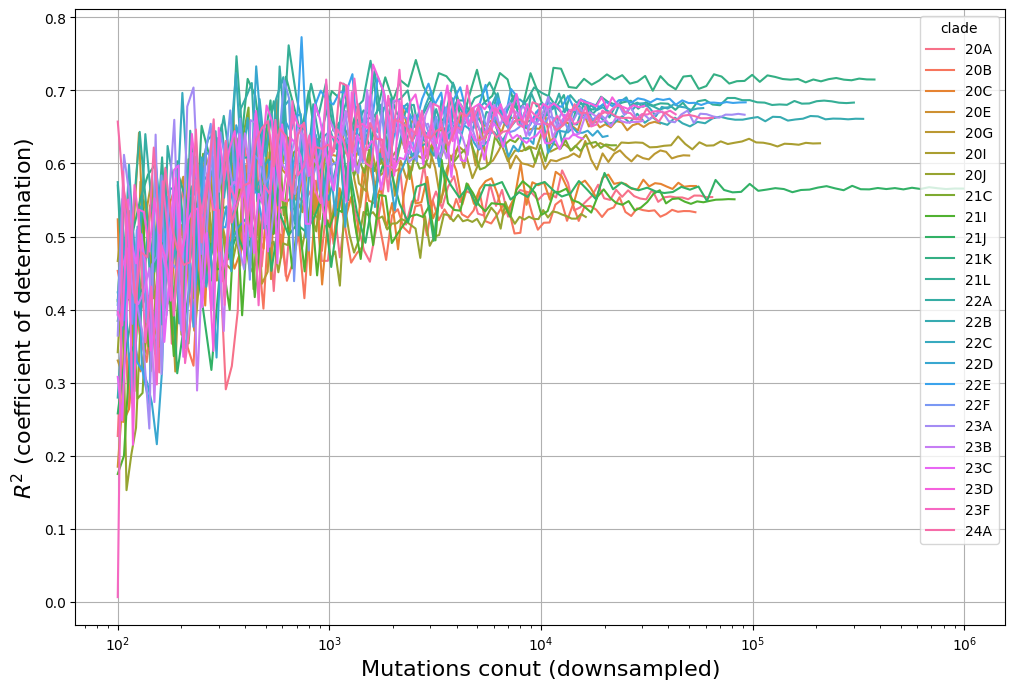

In [142]:
plt.figure(figsize=(12, 8))
sns.lineplot(sdata_full_df, x='n', y='r2', hue='clade')
# plt.hlines(0.63, 0, 10**6, 'k', '--')
plt.grid()
plt.ylabel('$R^2$ (coefficient of determination)', fontsize=16)
plt.xlabel('Mutations conut (downsampled)', fontsize=16)
plt.xscale('log')

## Site rate categories

### Categorize sites by mutation rate

In [9]:
from typing import Union
from Bio.SeqRecord import SeqRecord

def read_genbank_ref(gb: Union[str, SeqRecord]):
    if isinstance(gb, str):
        genome = next(SeqIO.parse(gb, "genbank"))
    elif isinstance(gb, SeqRecord):
        genome = gb
    else:
        raise NotImplementedError

    ftypes = {"CDS", "rRNA", "tRNA"}
    full_nucls = set("ACGT")
    data = []
    df: pd.DataFrame = None
    gene_qualifier = None
    for ftr in genome.features:
        if ftr.type == "source":
            source = ftr.extract(genome)
            seq = str(source.seq)
            for pos, nuc in enumerate(seq):
                context = seq[pos - 1: pos + 2]
                if len(context) < 3 or len(set(context).difference(full_nucls)) != 0:
                    context = None
                if nuc not in full_nucls:
                    nuc = context = None
                data.append({"Pos": pos + 1, "Nuc": nuc, "Context": context})
            df = pd.DataFrame(data)
            df["Strand"] = 0
            continue
        elif gene_qualifier is None and ftr.type in ftypes:
            for qualifier in ["gene", "product", "protein_id"]:
                if qualifier in ftr.qualifiers:
                    gene_qualifier = qualifier
                    break
            if gene_qualifier is None:
                raise RuntimeError(f"Cannot find any expected qualifier of feature: {ftr}; with following qualifiers: {ftr.qualifiers}")

        for pos in list(ftr.location):
            df.at[pos, "Type"] = ftr.type
            df.at[pos, "Strand"] = ftr.location.strand
            if ftr.type in ftypes:
                df.at[pos, qualifier] = ftr.qualifiers[qualifier][0]

    # add codon features
    df["PosInGene"] = -1
    df["PosInCodon"] = -1
    for gene_name in df[(df.Type == "CDS") & (df.Strand == 1)][gene_qualifier].unique():
        gdf = df[df[gene_qualifier] == gene_name]
        seq = gdf.Nuc.values
        for pos_in_gene, pos in enumerate(gdf.index):
            pic = pos_in_gene % 3
            cdn = seq[pos_in_gene - pic: pos_in_gene - pic + 3]
            cdn = "".join(cdn) if len(set(cdn).difference(full_nucls)) == 0 else None
            df.at[pos, "Codon"] = cdn
            df.at[pos, "PosInGene"] = pos_in_gene + 1
            df.at[pos, "PosInCodon"] = pic + 1

    df["Strand"] = df["Strand"].astype(np.int8)
    df["PosInCodon"] = df["PosInCodon"].astype(np.int8)
    df["PosInGene"] = df["PosInGene"].astype(np.int32)
    return df


In [10]:
ref_sites_df = read_genbank_ref('data/NC_045512.2.gb')
ref_sites_df = ref_sites_df[ref_sites_df.Codon.notna()]
# Pos and nt_site is the same
ref_sites_df

Pos Nuc Context  Strand         Type    gene  PosInGene  PosInCodon  \
265      266   A     GAT       1  mat_peptide  ORF1ab          1           1   
266      267   T     ATG       1  mat_peptide  ORF1ab          2           2   
267      268   G     TGG       1  mat_peptide  ORF1ab          3           3   
268      269   G     GGA       1  mat_peptide  ORF1ab          4           1   
269      270   A     GAG       1  mat_peptide  ORF1ab          5           2   
...      ...  ..     ...     ...          ...     ...        ...         ...   
29669  29670   C     ACA       1          CDS   ORF10        113           2   
29670  29671   A     CAT       1          CDS   ORF10        114           3   
29671  29672   T     ATA       1          CDS   ORF10        115           1   
29672  29673   A     TAG       1          CDS   ORF10        116           2   
29673  29674   G     AGC       1          CDS   ORF10        117           3   

      Codon  
265     ATG  
266     ATG  
267     ATG  
268     GAG  
269     GAG  
...     ...  
29669   ACA  
29670   ACA  
29671   TAG  
29672   TAG  
29673   TAG  

[29260 rows x 9 columns]

In [11]:
ref_sites_df['MutCountTotal'] = ref_sites_df['Pos'].map(obs_raw.groupby('nt_site')['count'].sum()).fillna(0.)
ref_sites_df['MutCountNonsyn'] = ref_sites_df['Pos'].map(obs.groupby('nt_site')['count'].sum()).fillna(0.)
ref_sites_df = ref_sites_df.merge(obs[['nt_site', 'codon_position']].drop_duplicates(), 
                   left_on='Pos', right_on='nt_site', how='left')
ref_sites_df

Pos Nuc Context  Strand         Type    gene  PosInGene  PosInCodon  \
0        266   A     GAT       1  mat_peptide  ORF1ab          1           1   
1        267   T     ATG       1  mat_peptide  ORF1ab          2           2   
2        268   G     TGG       1  mat_peptide  ORF1ab          3           3   
3        269   G     GGA       1  mat_peptide  ORF1ab          4           1   
4        270   A     GAG       1  mat_peptide  ORF1ab          5           2   
...      ...  ..     ...     ...          ...     ...        ...         ...   
29255  29670   C     ACA       1          CDS   ORF10        113           2   
29256  29671   A     CAT       1          CDS   ORF10        114           3   
29257  29672   T     ATA       1          CDS   ORF10        115           1   
29258  29673   A     TAG       1          CDS   ORF10        116           2   
29259  29674   G     AGC       1          CDS   ORF10        117           3   

      Codon  MutCountTotal  MutCountNonsyn  nt_site codon_position  
0       ATG            0.0             0.0      NaN            NaN  
1       ATG            2.0             2.0    267.0            2;2  
2       ATG            1.0             1.0    268.0            3;3  
3       GAG          239.0           239.0    269.0            1;1  
4       GAG          154.0           154.0    270.0            2;2  
...     ...            ...             ...      ...            ...  
29255   ACA          687.0           687.0  29670.0              2  
29256   ACA          114.0             1.0  29671.0              3  
29257   TAG           57.0             0.0      NaN            NaN  
29258   TAG           29.0             0.0      NaN            NaN  
29259   TAG          177.0             0.0      NaN            NaN  

[29260 rows x 13 columns]

In [12]:
ref_sites_df.MutCountTotal.sum(), obs_raw['count'].sum()

(np.float64(5611539.0), np.int64(5635999))

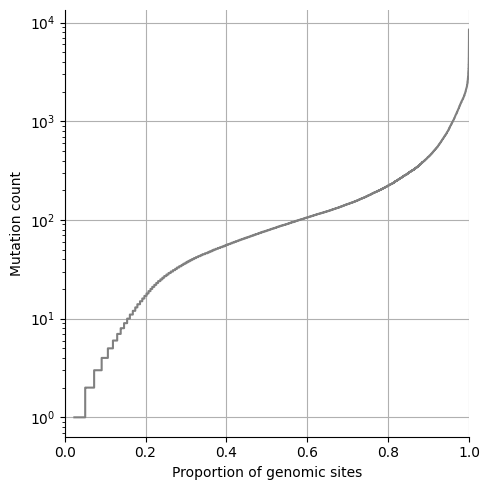

In [16]:
import matplotlib.patches as mpatches

sns.displot(ref_sites_df, y='MutCountTotal', kind='ecdf', log_scale=(False, True), color='gray')
# plt.legend([
#         # mpatches.Patch(color='none'), 
#         mpatches.Patch(color='none'),
#     ],[
#         'maximal mutations per site is 6323'], 
#     loc='upper left')
plt.grid(True)
plt.ylabel('Mutation count')
plt.xlabel('Proportion of genomic sites')
plt.tight_layout()
# plt.savefig('./figures/mutational_count_per_site_ecdf.pdf', dpi=300)
plt.show()

Processing: 1009 normal sites, 11 hotspots (>11.73)
Fitted Gamma (Normal sites): α = 0.452, Scale = 1.923


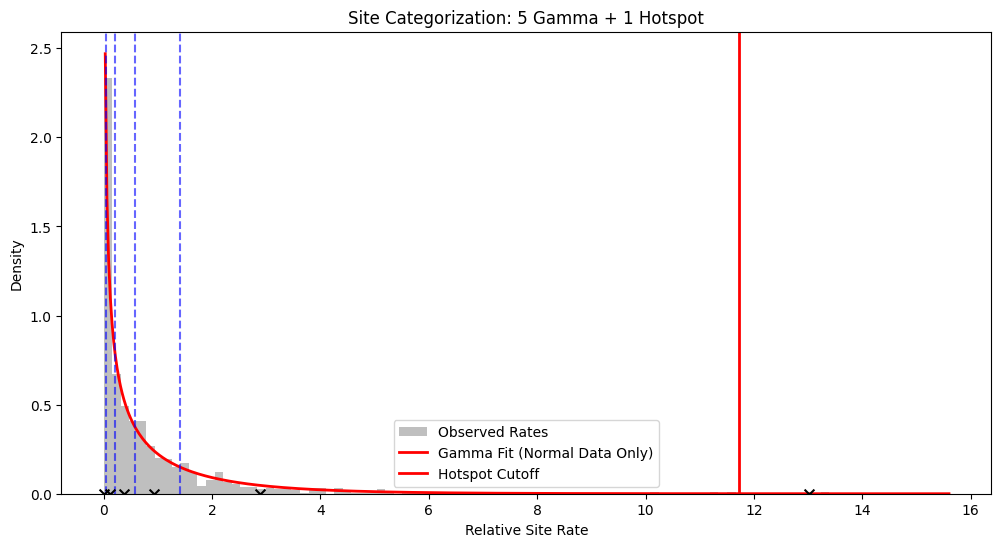

Discrete Rates: [ 0.01311099  0.11264672  0.37075813  0.93489407  2.89278533 13.01407147]


In [13]:
import numpy as np
from scipy.stats import gamma
import matplotlib.pyplot as plt

def calculate_truncated_mean(alpha, scale, lower, upper):
    """
    Calculates the conditional expectation E[X | lower < X < upper] 
    for a Gamma distribution analytically.
    """
    # The mean of a truncated Gamma is related to the CDF of Gamma(alpha + 1)
    # E[X] = alpha * scale * (F(u | a+1) - F(l | a+1)) / (F(u | a) - F(l | a))
    
    # Denominator: Probability mass in this bin
    prob_mass = gamma.cdf(upper, a=alpha, scale=scale) - gamma.cdf(lower, a=alpha, scale=scale)
    
    if prob_mass == 0:
        return 0.0
        
    # Numerator components using alpha + 1
    num_upper = gamma.cdf(upper, a=alpha+1, scale=scale)
    num_lower = gamma.cdf(lower, a=alpha+1, scale=scale)
    
    expected_value = (alpha * scale) * (num_upper - num_lower) / prob_mass
    return expected_value

def categorize_site_rates_robust(mut_counts, n_categories=6, hotspot_percentile=99.0, plot=False):
    """
    Categorize sites into Gamma-distributed rate categories, treating extreme outliers
    as a separate 'Hotspot' category.
    
    Parameters:
    - mut_counts: Array of mutation counts per site.
    - n_categories: Total categories (n-1 Gamma bins + 1 Hotspot bin).
    - hotspot_percentile: The cutoff (0-100) to define a hotspot.
    """
    # 1. Normalize to relative rates (Global Mean = 1.0)
    rates_observed = np.array(mut_counts, dtype=float)
    rates_observed = rates_observed / np.mean(rates_observed)
    
    # 2. Separate Hotspots from Normal sites
    # We use a percentile cut to identify the "Hot Tail"
    cutoff_value = np.percentile(rates_observed, hotspot_percentile)
    
    mask_normal = rates_observed <= cutoff_value
    mask_hotspot = rates_observed > cutoff_value
    
    rates_normal = rates_observed[mask_normal]
    rates_hotspot = rates_observed[mask_hotspot]
    
    print(f"Processing: {len(rates_normal)} normal sites, {len(rates_hotspot)} hotspots (>{cutoff_value:.2f})")
    
    # 3. Fit Gamma to NORMAL sites only
    # We lock location to 0.
    alpha, loc, scale = gamma.fit(rates_normal, floc=0)
    print(f"Fitted Gamma (Normal sites): α = {alpha:.3f}, Scale = {scale:.3f}")

    # 4. Discretize Gamma for Normal Sites
    # We use n_categories - 1 for the gamma, reserving 1 for hotspots
    n_gamma_cats = n_categories - 1
    
    # Create equal probability bins for the normal distribution
    quantiles = np.linspace(0, 1, n_gamma_cats + 1)
    
    # Convert probabilities to rate thresholds
    # Note: We clip the last threshold to the cutoff_value to ensure continuity
    gamma_thresholds = gamma.ppf(quantiles, a=alpha, scale=scale)
    gamma_thresholds[-1] = cutoff_value # Force the upper bound of Gamma to match the hotspot cutoff
    
    # 5. Calculate Representative Rates (Means)
    category_rates = []
    
    # A. Gamma Categories
    for i in range(n_gamma_cats):
        l, u = gamma_thresholds[i], gamma_thresholds[i+1]
        mean_rate = calculate_truncated_mean(alpha, scale, l, u)
        category_rates.append(mean_rate)
        
    # B. Hotspot Category
    # For the hotspot bin, we simply take the arithmetic mean of the observed outliers
    # because a Gamma fit usually fails to describe the extreme tail accurately.
    if len(rates_hotspot) > 0:
        hotspot_rate = np.mean(rates_hotspot)
    else:
        # Fallback if no hotspots exist (rare)
        hotspot_rate = cutoff_value * 1.5 
    category_rates.append(hotspot_rate)
    
    category_rates = np.array(category_rates)
    
    # 6. Assign Sites to Categories
    # We combine the gamma thresholds with infinity for the hotspot bin
    all_thresholds = np.concatenate([gamma_thresholds, [np.inf]])
    
    # digitize returns 1-based indices, we subtract 1 to get 0-indexed
    site_categories = np.digitize(rates_observed, all_thresholds[1:]) 
    
    # 7. Plotting
    if plot:
        plt.figure(figsize=(12, 6))
        
        # Histogram of all data (zoom in on relevant part)
        max_plot_x = np.percentile(rates_observed, 99.5) * 1.2
        bins = np.linspace(0, max_plot_x, 100)
        
        plt.hist(rates_observed, bins=bins, density=True, alpha=0.5, color='gray', label="Observed Rates")
        
        # Plot the Fitted Gamma (scaled to the proportion of normal data)
        x = np.linspace(0, max_plot_x, 500)
        # We multiply PDF by proportion of normal sites because the histogram includes hotspots
        prop_normal = len(rates_normal) / len(rates_observed)
        plt.plot(x, gamma.pdf(x, a=alpha, scale=scale) * prop_normal, 
                 'r-', lw=2, label=f"Gamma Fit (Normal Data Only)")
        
        # Plot thresholds
        for th in gamma_thresholds[1:-1]:
            plt.axvline(th, color='blue', linestyle='--', alpha=0.6)
            
        plt.axvline(cutoff_value, color='red', linestyle='-', lw=2, label="Hotspot Cutoff")
        
        # Visualize the discrete rates
        for rate in category_rates:
            plt.scatter(rate, 0, color='black', zorder=5, s=50, marker='x')

        plt.xlabel("Relative Site Rate")
        plt.ylabel("Density")
        plt.title(f"Site Categorization: {n_gamma_cats} Gamma + 1 Hotspot")
        plt.legend()
        plt.show()
        
    return site_categories, category_rates, alpha

# --- Example Usage ---
# Simulating data: Gamma distributed sites + some extreme outliers
np.random.seed(42)
normal_data = np.random.gamma(shape=0.5, scale=2.0, size=1000)
hotspots = np.random.normal(loc=15, scale=2, size=20) # Outliers
data = np.concatenate([normal_data, hotspots])

cats, rates, alpha = categorize_site_rates_robust(data, n_categories=6, plot=True)
print("Discrete Rates:", rates)

Processing: 27983 normal sites, 572 hotspots (>7.90)
Fitted Gamma (Normal sites): α = 0.658, Scale = 1.210


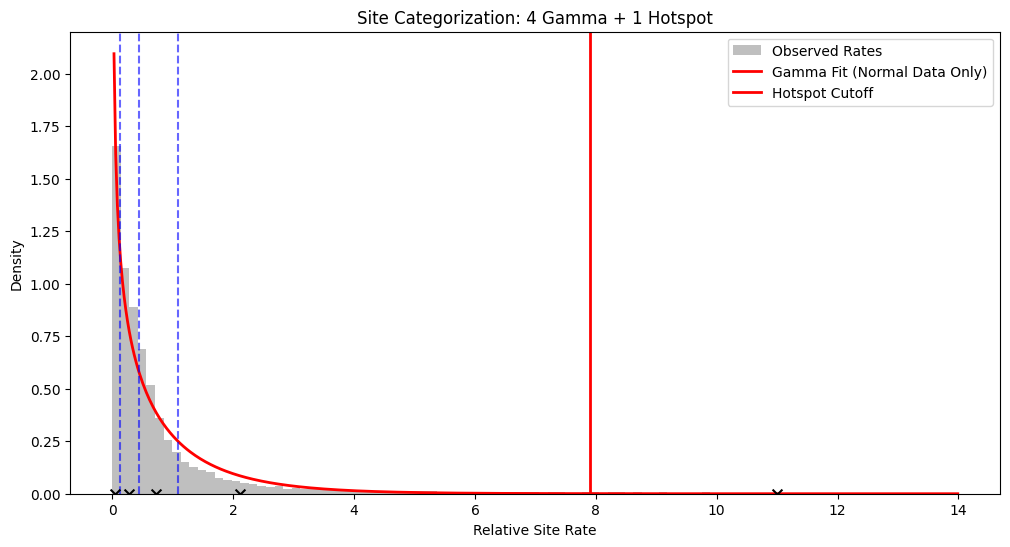

In [14]:
mut_counts = ref_sites_df['MutCountTotal']
categories, rates, alpha = categorize_site_rates_robust(mut_counts[mut_counts > 0], 5, 98, plot=True)

ref_sites_df['rate_cat'] = 0
ref_sites_df.loc[ref_sites_df.MutCountTotal > 0, 'rate_cat'] = categories + 1

Processing: 22639 normal sites, 462 hotspots (>8.59)
Fitted Gamma (Normal sites): α = 0.528, Scale = 1.437


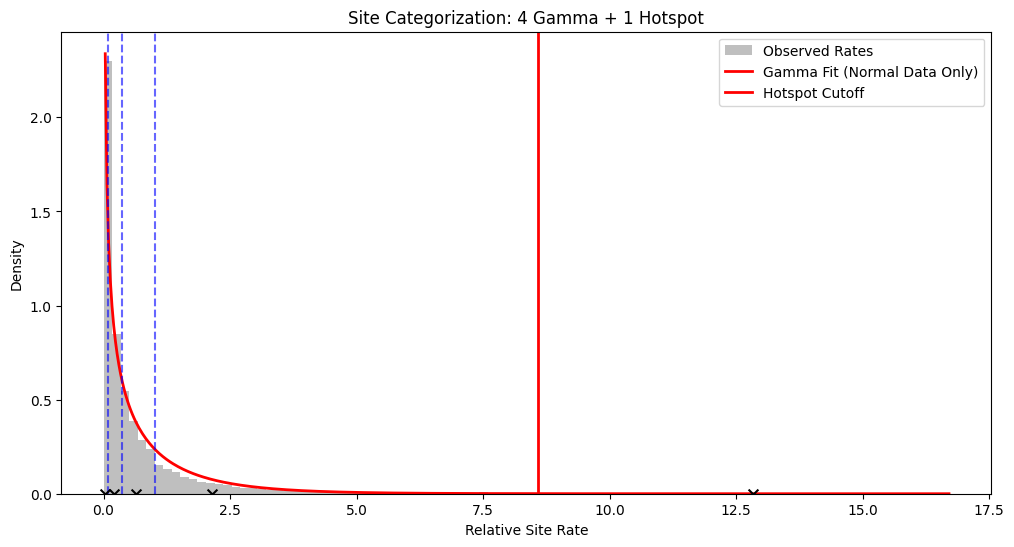

In [15]:
mut_counts = ref_sites_df['MutCountNonsyn']
categories, rates, alpha = categorize_site_rates_robust(mut_counts[mut_counts > 0], 5, 98, plot=True)
ref_sites_df['rate_cat_ns'] = 0
ref_sites_df.loc[ref_sites_df.MutCountNonsyn > 0, 'rate_cat_ns'] = categories + 1

In [16]:
ref_sites_df.groupby('rate_cat')['MutCountTotal'].agg(['count', 'mean', 'std', 'min', 'max', 'sum']).round(2)

count     mean     std     min     max        sum
rate_cat                                                   
0           705     0.00    0.00     0.0     0.0        0.0
1          6501     9.50    7.64     1.0    26.0    61742.0
2          8487    54.95   17.20    27.0    87.0   466388.0
3          7481   135.26   34.52    88.0   213.0  1011895.0
4          5514   514.30  320.96   214.0  1550.0  2835832.0
5           572  2160.28  776.61  1552.0  8529.0  1235682.0

In [17]:
ref_sites_df.groupby('rate_cat_ns')['MutCountNonsyn'].agg(['count', 'mean', 'std', 'min', 'max', 'sum']).round(2)

count     mean     std     min     max        sum
rate_cat_ns                                                   
0             6159     0.00    0.00     0.0     0.0        0.0
1             6410     4.43    3.09     1.0    11.0    28382.0
2             6183    27.81   10.93    12.0    49.0   171978.0
3             5341    85.92   25.47    50.0   139.0   458890.0
4             4703   361.15  239.44   140.0  1180.0  1698498.0
5              464  1762.09  731.40  1181.0  8529.0   817611.0

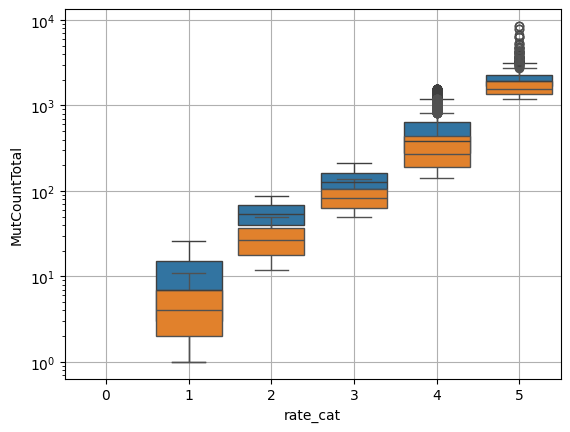

In [76]:
sns.boxplot(ref_sites_df, x='rate_cat', y='MutCountTotal',)
sns.boxplot(ref_sites_df, x='rate_cat_ns', y='MutCountNonsyn',)
plt.yscale('log')
plt.grid(True)

In [18]:
ref_sites_df.groupby('rate_cat').MutCountTotal.agg(['min', 'max',])

min     max
rate_cat                
0            0.0     0.0
1            1.0    26.0
2           27.0    87.0
3           88.0   213.0
4          214.0  1550.0
5         1552.0  8529.0

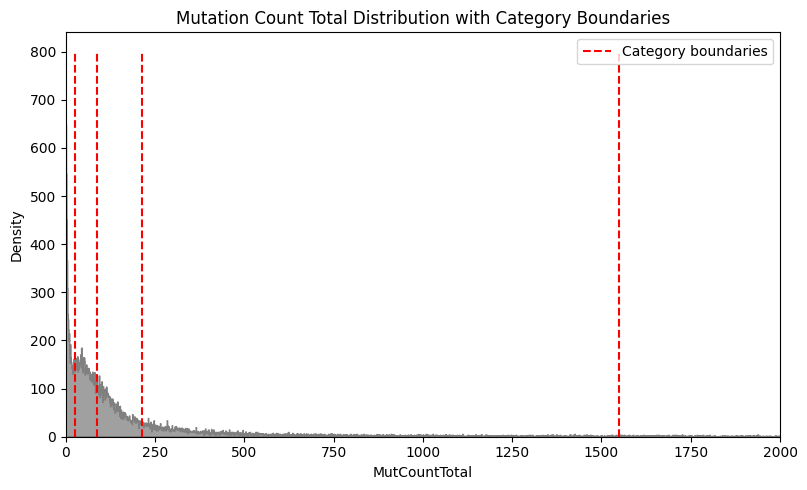

In [88]:
plt.figure(figsize=(8, 5))
sns.histplot(ref_sites_df, x='MutCountTotal', color='gray', element='step', discrete=True)
plt.vlines([26, 87, 213, 1550], ymin=0, ymax=800, color='red', linestyle='--', label='Category boundaries')

plt.title("Mutation Count Total Distribution with Category Boundaries")
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.xlim(0, 2000)
plt.show()

In [19]:
assert ref_sites_df.Codon.isna().sum() == 0

ref_sites_df['AA'] = ref_sites_df['Codon'].apply(coda.translate_codon).map(amino_acid_codes)

In [20]:
ref_sites_df[['Pos', 'MutCountTotal', 'MutCountNonsyn', 'rate_cat', 'rate_cat_ns']]\
    .to_csv('data/ref_sites_rates_cat5.csv', index=False, float_format='%g')

### Fitting observed substitution spectra by site-specific rates

In [21]:
ref_sites_df.query('rate_cat == 1').head()

Pos Nuc Context  Strand         Type    gene  PosInGene  PosInCodon  \
1    267   T     ATG       1  mat_peptide  ORF1ab          2           2   
2    268   G     TGG       1  mat_peptide  ORF1ab          3           3   
129  395   C     TCA       1  mat_peptide  ORF1ab        130           1   
157  423   T     TTA       1  mat_peptide  ORF1ab        158           2   
265  531   T     GTA       1  mat_peptide  ORF1ab        266           2   

    Codon  MutCountTotal  MutCountNonsyn  nt_site codon_position  rate_cat  \
1     ATG            2.0             2.0    267.0            2;2         1   
2     ATG            1.0             1.0    268.0            3;3         1   
129   CAA           26.0            25.0    395.0            1;1         1   
157   TTA           12.0            12.0    423.0            2;2         1   
265   GTA           13.0            13.0    531.0            2;2         1   

     rate_cat_ns   AA  
1              1  Met  
2              1  Met  
129            2  Gln  
157            2  Leu  
265            2  Val

In [ ]:
# rate cats based on all mutations

# check 3 different approaches to get amino acid counts for normalization
def get_site_specific_aa_counts(site_cat):
    aa_counts = ref_sites_df.query('AA != "*" & rate_cat == @site_cat').AA.value_counts().to_dict()
    return aa_counts

def get_uniform_aa_counts():
    return {x: 1 for x in amino_acid_codes.values()}
    
def get_original_aa_counts(df_obs):
    _orig_aa_cnt = df_obs.query('aa1 != "*"').groupby('aa1')['count'].sum()\
        .rename(index=amino_acid_codes).to_dict()
    return _orig_aa_cnt


metrics_total = []
d_to_eq_data = []
for clade in tqdm.tqdm(clades_spectra.clade.unique(), desc='Clades'):
    spectrum_clade = clades_spectra[clades_spectra['clade'] == clade].copy()
    spectrum_clade['rate'] /= spectrum_clade['rate'].sum()

    exp_aa_subst, _ = prepare_exp_aa_subst(spectrum_clade, 'rate', 1)
    obs_clade = obs[obs['clade'] == clade]

    for i, rcat in enumerate(ref_sites_df.rate_cat.unique()):
        cur_sites = ref_sites_df.query('rate_cat == @rcat').Pos.tolist()
        df_obs = obs_clade[obs_clade.nt_site.isin(cur_sites)]
        if len(df_obs) == 0:
            continue
        
        cur_aa_freqs_dct = get_site_specific_aa_counts(rcat)
        # cur_aa_freqs_dct = get_original_aa_counts(df_obs)

        aa_subst = prepare_aa_subst(df_obs, exp_aa_subst, cur_aa_freqs_dct)
        
        cur_metrics = calc_metrics(aa_subst)
        cur_metrics['nt_sites'] = df_obs.nt_site.nunique()
        cur_metrics['clade'] = clade
        cur_metrics['rate_cat'] = rcat
        metrics_total.append(cur_metrics)

        # Distance to equilibrium estimation
        _, cur_aa_freq = get_equilibrium_freqs(spectrum_clade, 'rate')
        cur_aa_freq['obs_cnt'] = cur_aa_freq['aa'].map(cur_aa_freqs_dct).fillna(0)
        cur_aa_freq['obs_freq'] = cur_aa_freq['obs_cnt'] / cur_aa_freq['obs_cnt'].sum()

        dm = cityblock(cur_aa_freq['eq_freq'], cur_aa_freq['obs_freq'])
        de = euclidean(cur_aa_freq['eq_freq'], cur_aa_freq['obs_freq'])

        simple_metric = cur_aa_freq.sort_values('eq_freq').tail().sum().drop('obs_cnt').to_dict()

        d_to_eq_data.append({
            'clade': clade,
            'rcat': rcat,
            'cityblock': dm, 
            'euclidean': de, 
            'top5_eq_frac': simple_metric['eq_freq'],
            'top5_obs_frac': simple_metric['obs_freq'],
            'top5': simple_metric['aa'],
        })

    # for total sites set
    aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, aa_freqs_total_dct)
    # aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, get_uniform_aa_counts())
    cur_metrics = calc_metrics(aa_subst)
    cur_metrics['nt_sites'] = obs_clade.nt_site.nunique()
    cur_metrics['clade'] = clade
    cur_metrics['rate_cat'] = 'total'
    metrics_total.append(cur_metrics)

metrics_total_df = pd.DataFrame(metrics_total).set_index(['clade', 'rate_cat', 'nt_sites'])\
        .drop(['mape','wape','slope','intercept', 'ks_stat','ks_p','rmse','log_likelihood'], axis=1)
metrics_total_df.to_csv('data/fit_metrics_site_rate_cat5.csv', float_format='%g')

d_to_eq_df = pd.DataFrame(d_to_eq_data)
d_to_eq_df.to_csv('data/dist_to_eq_site_rate_cat5.csv', float_format='%g', index=False)

Clades:   0%|          | 0/24 [00:00<?, ?it/s]

Clades: 100%|██████████| 24/24 [00:08<00:00,  2.95it/s]


In [ ]:
# rate cats based on nonsynonymous mutations

# check 3 different approaches to get amino acid counts for normalization
def get_site_specific_aa_counts(site_cat):
    aa_counts = ref_sites_df.query('AA != "*" & rate_cat_ns == @site_cat').AA.value_counts().to_dict()
    return aa_counts

def get_uniform_aa_counts():
    return {x: 1 for x in amino_acid_codes.values()}
    
def get_original_aa_counts(df_obs):
    _orig_aa_cnt = df_obs.query('aa1 != "*"').groupby('aa1')['count'].sum()\
        .rename(index=amino_acid_codes).to_dict()
    return _orig_aa_cnt


metrics_total = []
d_to_eq_data = []
for clade in tqdm.tqdm(clades_spectra.clade.unique(), desc='Clades'):
    spectrum_clade = clades_spectra[clades_spectra['clade'] == clade].copy()
    spectrum_clade['rate'] /= spectrum_clade['rate'].sum()

    exp_aa_subst, _ = prepare_exp_aa_subst(spectrum_clade, 'rate', 1)
    obs_clade = obs[obs['clade'] == clade]

    for i, rcat in enumerate(ref_sites_df.rate_cat_ns.unique()):
        cur_sites = ref_sites_df.query('rate_cat_ns == @rcat').Pos.tolist()
        df_obs = obs_clade[obs_clade.nt_site.isin(cur_sites)]
        if len(df_obs) == 0:
            continue
        
        cur_aa_freqs_dct = get_site_specific_aa_counts(rcat)
        # cur_aa_freqs_dct = get_original_aa_counts(df_obs)

        aa_subst = prepare_aa_subst(df_obs, exp_aa_subst, cur_aa_freqs_dct)
        
        cur_metrics = calc_metrics(aa_subst)
        cur_metrics['nt_sites'] = df_obs.nt_site.nunique()
        cur_metrics['clade'] = clade
        cur_metrics['rate_cat_ns'] = rcat
        metrics_total.append(cur_metrics)

        # Distance to equilibrium estimation
        _, cur_aa_freq = get_equilibrium_freqs(spectrum_clade, 'rate')
        cur_aa_freq['obs_cnt'] = cur_aa_freq['aa'].map(cur_aa_freqs_dct).fillna(0)
        cur_aa_freq['obs_freq'] = cur_aa_freq['obs_cnt'] / cur_aa_freq['obs_cnt'].sum()

        dm = cityblock(cur_aa_freq['eq_freq'], cur_aa_freq['obs_freq'])
        de = euclidean(cur_aa_freq['eq_freq'], cur_aa_freq['obs_freq'])

        d_to_eq_data.append({
            'clade': clade,
            'rcat': rcat,
            'cityblock': dm, 
            'euclidean': de, 
        })

    # for total sites set
    aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, aa_freqs_total_dct)
    # aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, get_uniform_aa_counts())
    cur_metrics = calc_metrics(aa_subst)
    cur_metrics['nt_sites'] = obs_clade.nt_site.nunique()
    cur_metrics['clade'] = clade
    cur_metrics['rate_cat_ns'] = 'total'
    metrics_total.append(cur_metrics)

metrics_total_df = pd.DataFrame(metrics_total).set_index(['clade', 'rate_cat_ns', 'nt_sites'])\
        .drop(['mape','wape','slope','intercept', 'ks_stat','ks_p','rmse','log_likelihood'], axis=1)
metrics_total_df.to_csv('data/fit_metrics_site_rate_cat_ns5.csv', float_format='%g')

d_to_eq_df = pd.DataFrame(d_to_eq_data)
d_to_eq_df['time_period'] = d_to_eq_df['clade'].map(_clade2label)
d_to_eq_df.to_csv('data/dist_to_eq_site_rate_cat_ns5.csv', float_format='%g', index=False)

Clades: 100%|██████████| 24/24 [00:10<00:00,  2.38it/s]


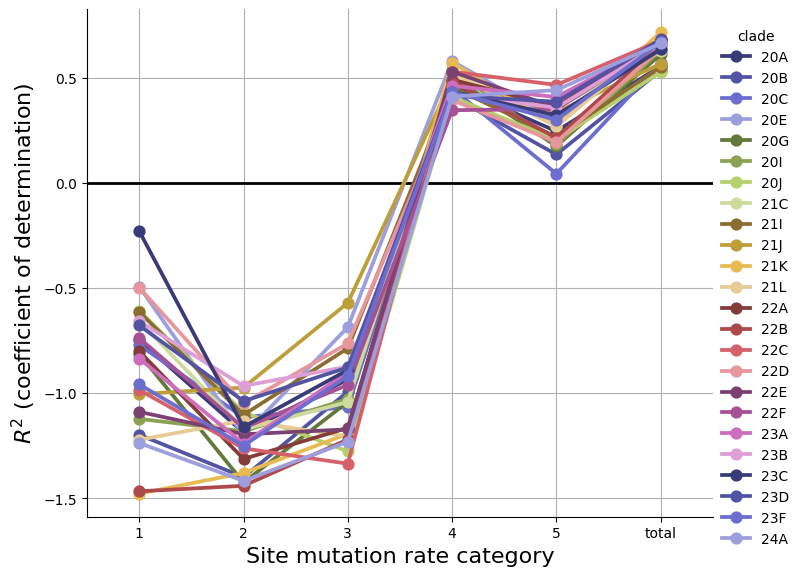

In [294]:
_ = metrics_total_df.reset_index().melt(
    ['clade', 'rate_cat_ns'], ['r2', ])

g = sns.catplot(
    data=_, y='value', col='variable', x='rate_cat_ns', hue='clade',
    kind='point', height=6, aspect=1.2, sharey=False, palette='tab20b',
    order=list(range(1,6))+['total'],
)
for ax in g.axes.flat:
    ax.grid()
    ax.set_axisbelow(True)
    ax.set_title('')
    ax.set_ylabel('$R^2$ (coefficient of determination)', fontsize=16)
    ax.set_xlabel('Site mutation rate category', fontsize=16)
    bou = ax.get_xbound()
    ax.hlines(0, *bou, color='black', linestyle='-', linewidth=2, zorder=1)
    ax.set_xlim(bou)


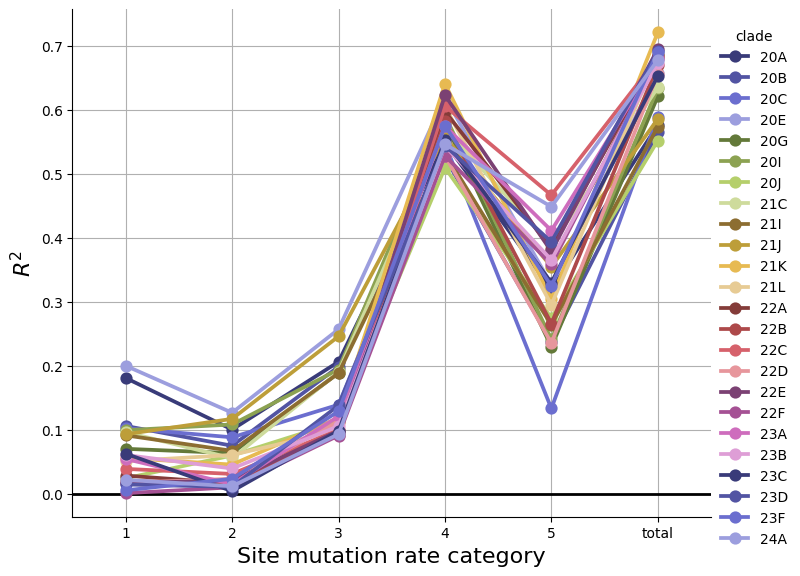

In [295]:
_ = metrics_total_df.reset_index().melt(
    ['clade', 'rate_cat_ns'], ['pearson_corr_squared', ])

g = sns.catplot(
    data=_, y='value', col='variable', x='rate_cat_ns', hue='clade',
    kind='point', height=6, aspect=1.2, sharey=False, palette='tab20b',
    order=list(range(1,6))+['total'],
)
for ax in g.axes.flat:
    ax.grid()
    ax.set_axisbelow(True)
    ax.set_title('')
    ax.set_ylabel('$R^2$', fontsize=16)
    ax.set_xlabel('Site mutation rate category', fontsize=16)
    bou = ax.get_xbound()
    ax.hlines(0, *bou, color='black', linestyle='-', linewidth=2, zorder=1)
    ax.set_xlim(bou)


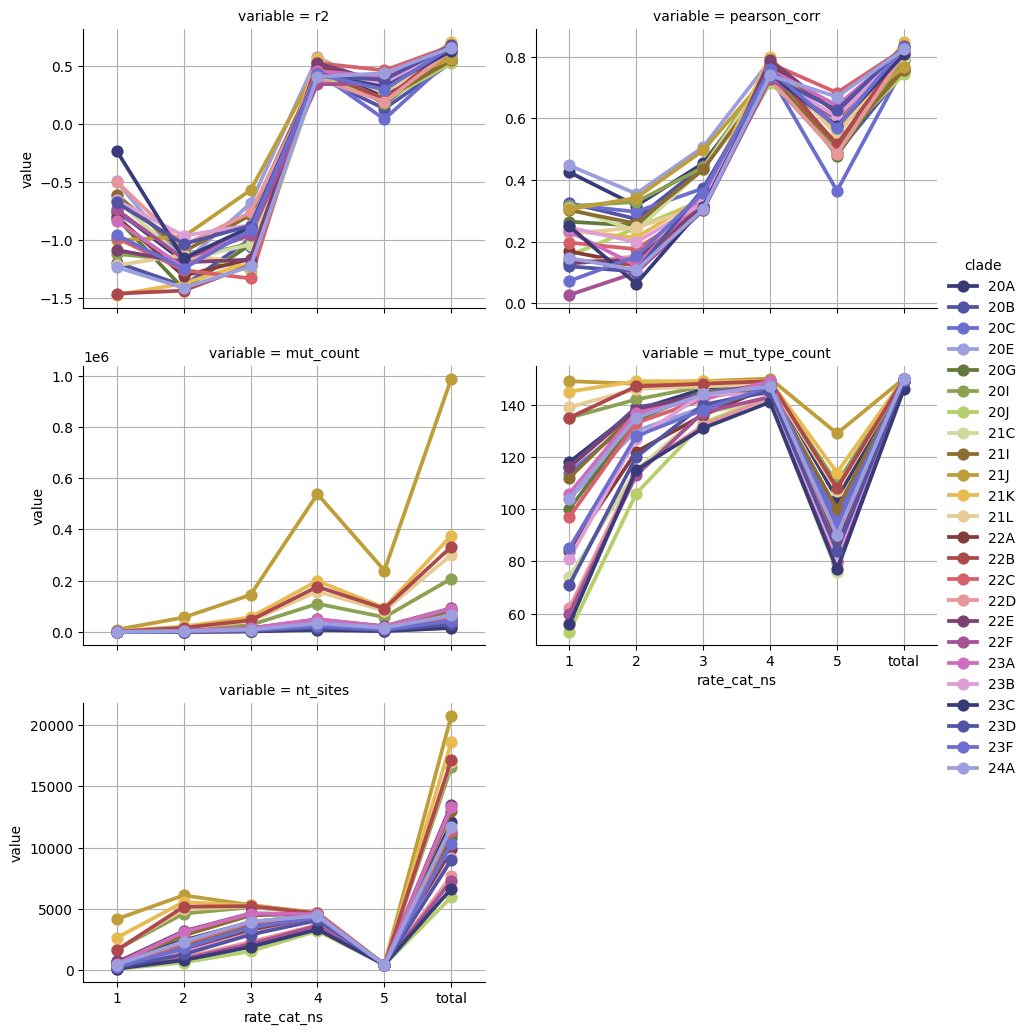

In [298]:
_ = metrics_total_df.reset_index().melt(
    ['clade', 'rate_cat_ns'], ['r2', 'pearson_corr', 'mut_count', 'mut_type_count','nt_sites'])

g = sns.catplot(
    data=_, y='value', col='variable', x='rate_cat_ns', hue='clade',
    col_wrap=2, kind='point', height=4, aspect=1.2, sharey=False, palette='tab20b',
    order=list(range(1,6))+['total'],
)
for ax in g.axes.flat:
    ax.grid()
    ax.set_axisbelow(True)

# g.axes_dict['mut_count'].set_ylim(0, 200000)

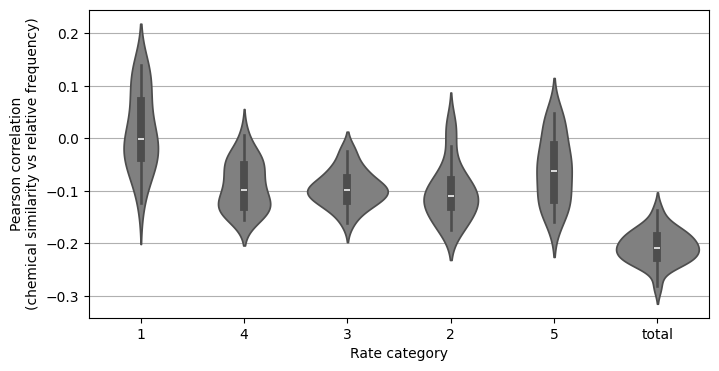

In [38]:
plt.figure(figsize=(8, 4))
ax=sns.violinplot(
    data=metrics_total_df.reset_index(), 
    x='rate_cat_ns', y='corr_chem_vs_rel_freq', color='gray')
plt.ylabel('Pearson correlation\n(chemical similarity vs relative frequency)',)
plt.xlabel('Rate category')
ax.set_axisbelow(True)
plt.grid(True, axis='y')

### Distance to equilibrium VIZ

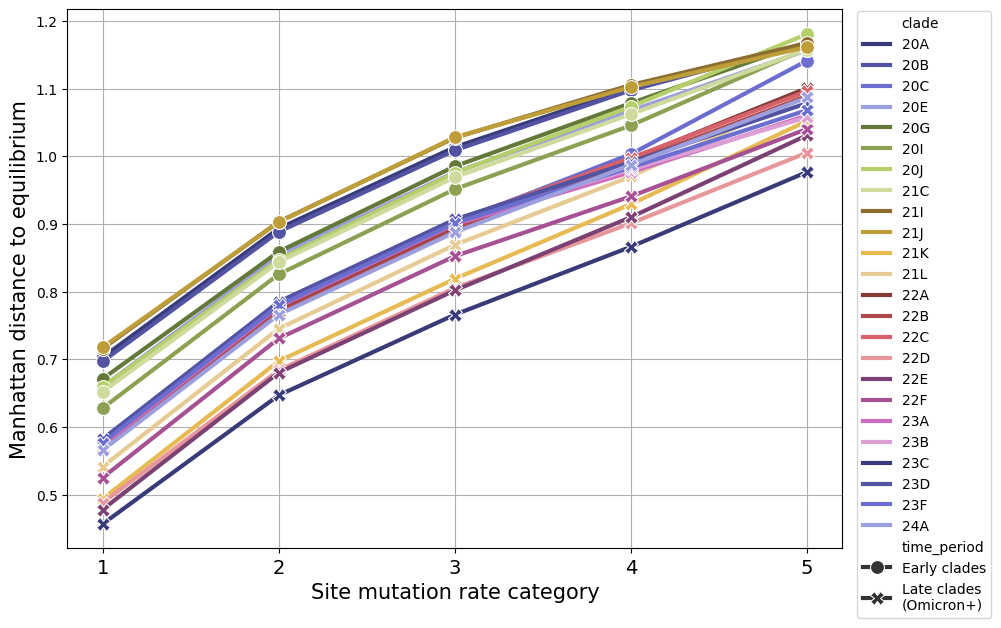

In [303]:
plt.figure(figsize=(10, 7))
ax = sns.lineplot(
    d_to_eq_df, x='rcat', y='cityblock', hue='clade', style='time_period', 
    markers=True, dashes=False, palette='tab20b', 
    linewidth=3, markersize=10, 
)

ax.grid()
ax.set_axisbelow(True)
ax.set_title('')
ax.set_xticks(range(1, 6))
ax.set_ylabel('Manhattan distance to equilibrium', fontsize=15)
ax.set_xlabel('Site mutation rate category', fontsize=15)

plt.legend(bbox_to_anchor=(1.01, 1.01), loc='upper left')
# plt.grid(axis='y', alpha=0.7)
plt.xticks(fontsize=14)
plt.show()

### Calculate aa content of most variable and constant sites

In [ ]:
# add indexes to amino acids
naa = ref_sites_df.query('AA != "*"').shape[0] // 3
aa_indexes = np.repeat(np.arange(naa), 3)+1
ref_sites_df['aa_index'] = -1
ref_sites_df.loc[(ref_sites_df['AA'] != "*"), 'aa_index'] = aa_indexes

In [284]:
ref_sites_df.tail(3100).head(10)

Pos Nuc Context  Strand Type gene  PosInGene  PosInCodon Codon  \
26160  26465   T     CTG       1  CDS    E        221           2   CTG   
26161  26466   G     TGG       1  CDS    E        222           3   CTG   
26162  26467   G     GGT       1  CDS    E        223           1   GTC   
26163  26468   T     GTC       1  CDS    E        224           2   GTC   
26164  26469   C     TCT       1  CDS    E        225           3   GTC   
26165  26470   T     CTA       1  CDS    E        226           1   TAA   
26166  26471   A     TAA       1  CDS    E        227           2   TAA   
26167  26472   A     AAA       1  CDS    E        228           3   TAA   
26168  26523   A     CAT       1  CDS    M          1           1   ATG   
26169  26524   T     ATG       1  CDS    M          2           2   ATG   

       MutCountTotal  MutCountNonsyn  nt_site codon_position  rate_cat  \
26160           57.0            57.0  26465.0              2         2   
26161          161.0             0.0      NaN            NaN         3   
26162          929.0           929.0  26467.0              1         4   
26163           35.0            35.0  26468.0              2         2   
26164          370.0             0.0      NaN            NaN         4   
26165            2.0             0.0      NaN            NaN         1   
26166            8.0             0.0      NaN            NaN         1   
26167           11.0             0.0      NaN            NaN         1   
26168            6.0             6.0  26523.0              1         1   
26169            5.0             5.0  26524.0              2         1   

       rate_cat_ns   AA  aa_index  
26160            3  Leu      8546  
26161            0  Leu      8546  
26162            4  Val      8547  
26163            2  Val      8547  
26164            0  Val      8547  
26165            0    *        -1  
26166            0    *        -1  
26167            0    *        -1  
26168            1  Met      8548  
26169            1  Met      8548

In [289]:
aa_mutability = ref_sites_df.query('AA != "*"').groupby(['aa_index', 'AA'])['MutCountNonsyn'].sum()
aa_mutability = aa_mutability.sort_values()

n = 2000 # number of sites to consider as most variable or most constant
constant_sites_aa_content = aa_mutability.head(n).reset_index()['AA'].value_counts().to_dict()
variable_sites_aa_content = aa_mutability.tail(n).reset_index()['AA'].value_counts().to_dict()

In [290]:
_, cur_aa_freq = get_equilibrium_freqs(spectrum_20A, 'rate')
cur_aa_freq['var_sites'] = cur_aa_freq['aa'].map(variable_sites_aa_content)
cur_aa_freq['const_sites'] = cur_aa_freq['aa'].map(constant_sites_aa_content)
cur_aa_freq['var_freq'] = cur_aa_freq['var_sites'] / cur_aa_freq['var_sites'].sum()
cur_aa_freq['const_freq'] = cur_aa_freq['const_sites'] / cur_aa_freq['const_sites'].sum()
cur_aa_freq

aa   eq_freq  var_sites  const_sites  var_freq  const_freq
0   Phe  0.314637         16          159    0.0080      0.0795
1   Leu  0.197825        211          354    0.1055      0.1770
2   Ser  0.119281        180          130    0.0900      0.0650
3   Ile  0.086898         63           98    0.0315      0.0490
4   Tyr  0.073639         22          158    0.0110      0.0790
5   Val  0.044165        121          103    0.0605      0.0515
6   Cys  0.035283         38          121    0.0190      0.0605
7   Thr  0.025257        262           85    0.1310      0.0425
8   His  0.020183         76           52    0.0380      0.0260
9   Pro  0.017862        150           55    0.0750      0.0275
10  Asn  0.017199         25          105    0.0125      0.0525
11  Arg  0.009142         99           65    0.0495      0.0325
12  Asp  0.008012         84           54    0.0420      0.0270
13  Ala  0.007127        256           57    0.1280      0.0285
14  Met  0.006878         65           34    0.0325      0.0170
15  Gln  0.005073         79           83    0.0395      0.0415
16  Lys  0.004677         62           54    0.0310      0.0270
17  Gly  0.002844        114          144    0.0570      0.0720
18  Glu  0.002015         58           47    0.0290      0.0235
19  Trp  0.002004         19           42    0.0095      0.0210

In [291]:
cur_aa_freq.sort_values('eq_freq').tail().sum()

aa             TyrIleSerLeuPhe
eq_freq               0.792281
var_sites                  492
const_sites                899
var_freq                 0.246
const_freq              0.4495
dtype: object

In [292]:
d_var = cityblock(cur_aa_freq['eq_freq'], cur_aa_freq['var_freq'])
d_const = cityblock(cur_aa_freq['eq_freq'], cur_aa_freq['const_freq'])
print(d_var, d_const)

1.1345236738029898 0.696283075519111


## view the scatterplots with negative R2

In [ ]:
def plot_subst_freqs_linear(aa_subst, title=''):
    aa_subst = aa_subst.copy()

    y_true, y_pred = aa_subst['nobs_freqs'], aa_subst['nexp_freqs']
    cor_res = spearmanr(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"Spearman correlation: {cor_res.correlation:.3f} (p-value: {cor_res.pvalue:.3g})")

    plt.figure(figsize=(8, 8))
    ax = sns.regplot(aa_subst, color='blue', scatter_kws={'alpha':0.5, 's':50},
                y='nobs_freqs', x='nexp_freqs')

    _max = round(max(y_true), 2)
    plt.plot([0, _max], [0, _max], color='black', linestyle='--',)
    plt.ylabel('Observed AA substitution frequencies', fontsize=16)
    plt.xlabel('Predicted AA substitution frequencies', fontsize=16)
    plt.grid()
    # plt.ylabel('Наблюдаемые частоты замещений аминокислот', fontsize=14)
    # plt.xlabel('Ожидаемые частоты замещений аминокислот', fontsize=14)
    plt.title(title, fontsize=16)
    # plt.legend(title=f"spearmanr={cor_res.correlation:.2f} (p={cor_res.pvalue:.1g})", title_fontsize=14)
    plt.legend(title=f"$R^2$ = {r2:.2f}", title_fontsize=16)
    # plt.savefig('./figures/obs_exp_aa_freqs_20A.pdf')
    plt.show()

In [19]:
aa_subst_total_df = pd.read_csv('data/aa_subst_total_rates.csv', index_col=0)
aa_subst_total_df

aa1  aa2  nobs  ref_aa1_freq  nobs_scaled  rate_exp       nexp  \
0      Ala  Asp    75      0.118787     34.71640  0.299600    43.8053   
1      Ala  Glu     6      0.118787      2.77731  0.299600    43.8053   
2      Ala  Gly     8      0.118787      3.70308  0.210660    30.8012   
3      Ala  Pro    13      0.118787      6.01751  0.457080    66.8309   
4      Ala  Ser  1119      0.118787    517.96800  9.487600  1387.2100   
...    ...  ...   ...           ...          ...       ...        ...   
32395  Val  Gly    45      0.078016     29.68430  0.173924    17.9375   
32396  Val  Ile   466      0.078016    307.39800  2.494230   257.2400   
32397  Val  Leu   258      0.078016    170.19000  2.614820   269.6770   
32398  Val  Met    32      0.078016     21.10890  0.831410    85.7465   
32399  Val  Phe   209      0.078016    137.86700  2.228000   229.7820   

            diff         pe  nobs_freqs  nexp_freqs clade branches  \
0       -9.08895   -26.1806    0.001049    0.001324   20A      all   
1      -41.02800 -1477.2600    0.000084    0.001324   20A      all   
2      -27.09810  -731.7720    0.000112    0.000931   20A      all   
3      -60.81340 -1010.6100    0.000182    0.002020   20A      all   
4     -869.23900  -167.8170    0.015655    0.041926   20A      all   
...          ...        ...         ...         ...   ...      ...   
32395   11.74690    39.5726    0.001486    0.000898   24A      all   
32396   50.15810    16.3170    0.015388    0.012877   24A      all   
32397  -99.48640   -58.4560    0.008520    0.013500   24A      all   
32398  -64.63770  -306.2110    0.001057    0.004292   24A      all   
32399  -91.91510   -66.6693    0.006902    0.011503   24A      all   

        sites_sample  sample_cutoff  
0      most variable             10  
1      most variable             10  
2      most variable             10  
3      most variable             10  
4      most variable             10  
...              ...            ...  
32395         random             30  
32396         random             30  
32397         random             30  
32398         random             30  
32399         random             30  

[32400 rows x 15 columns]

In [ ]:
i=0
for _, gr in aa_subst_total_df.groupby(['clade', 'branches', 'sites_sample', 'sample_cutoff']):
    cur_metrics = calc_metrics(gr)
    r2 = cur_metrics['r2']
    i+=1
    # if i > 5:
    #     break
    # if r2<-1.6:
        # gr['nexp_freqs'] = gr['nobs_freqs'].mean()
    if r2>.8:
        print(r2)
        break

0.8003752243601783


In [82]:
gr['nexp_freqs'] = gr['nobs_freqs'].mean()
r2_score(gr['nobs_freqs'], gr['nexp_freqs'])

0.0

In [83]:
gr['nexp_freqs'] = gr['nobs_freqs'].mean()
gr['nexp_freqs'] /= gr['nexp_freqs'].sum()
r2_score(gr['nobs_freqs'], gr['nexp_freqs'])

-2.220446049250313e-16

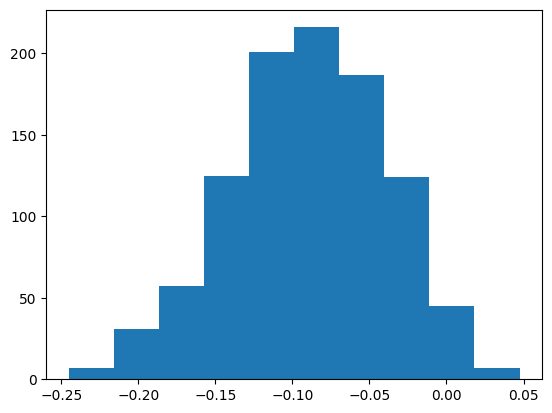

In [80]:
_d = []
for _ in range(1000):
    gr['nexp_freqs'] = np.random.random(len(gr))
    gr['nexp_freqs'] /= gr['nexp_freqs'].sum()
    r2 = r2_score(gr['nobs_freqs'], gr['nexp_freqs'])
    _d.append(r2)
plt.hist(_d);

/home/kpotoh/.pyenv/.venv_bio/lib64/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


-0.10662335407434731
Spearman correlation: -0.017 (p-value: 0.834)


/tmp/ipykernel_19245/544917984.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f"$R^2$ = {r2:.2f}", title_fontsize=16)


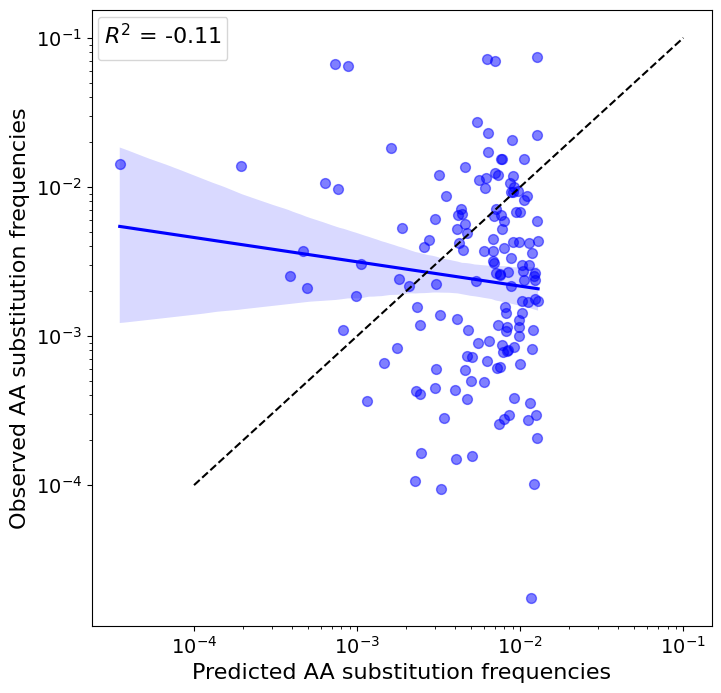

In [73]:
plot_subst_freqs(gr)

Spearman correlation: 0.811 (p-value: 2.45e-36)


/tmp/ipykernel_19245/3066355826.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f"$R^2$ = {r2:.2f}", title_fontsize=16)


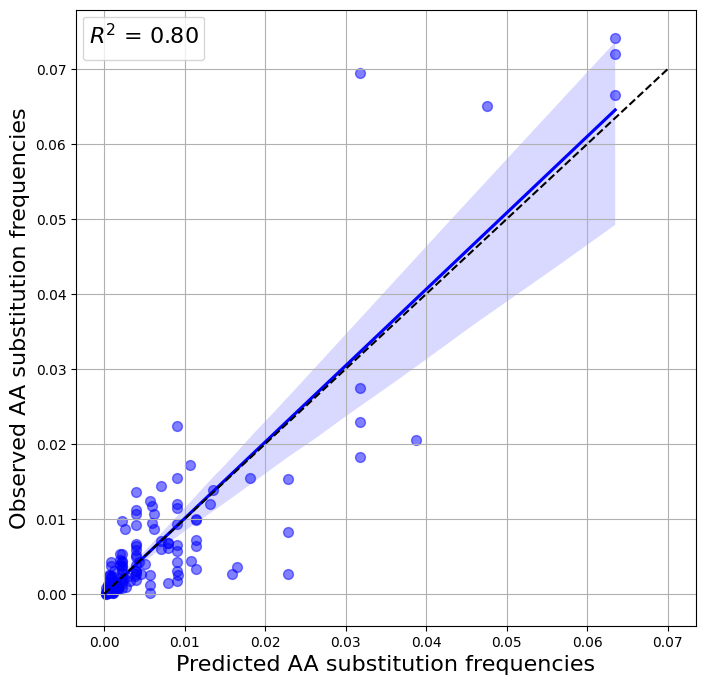

In [59]:
plot_subst_freqs_linear(gr)